In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import numpy as np

# Read the list of filenames from the configuration file
with open('file_list.txt', 'r', encoding='utf-8') as config_file:
    file_names = config_file.read().splitlines()

# Regex pattern to match the data format
pattern = r'\[(.*?)\] (.*?): (.*)'

# Initialize an empty list to store parsed data
datalist = []
stream_count = 0
# Iterate over each specified file
for file in file_names:
    full_path = "data\\"+file
    with open(full_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()
        for line in lines:
            match = re.match(pattern, line)
            if match:
                date, user, message = match.groups()
                datalist.append([date, user, message,stream_count])
    stream_count = stream_count + 1

# Create a DataFrame from the parsed data
data = pd.DataFrame(datalist, columns=["date", "user", "message","stream"])

In [2]:
#date to date format and sorting with it
data['date'] = pd.to_datetime(data['date'])
#data = data.sort_values(by=['user', 'date'])

In [3]:
data.shape

(326020, 4)

In [4]:
#first messege for each user
data['first_message'] = data.groupby('user').cumcount().apply(lambda x: 1 if x == 0 else 0)

In [5]:
#unique chaterrs each stream
unique_chatters_per_stream = data.groupby('stream')['user'].nunique()

In [6]:
# Calculate the number of first messages per stream
first_messages_per_stream = data.groupby('stream')['first_message'].sum()


# Calculate the total number of messages per stream
total_messages_per_stream = data['stream'].value_counts()

# Combine the results into a single DataFrame
stream_stats = pd.DataFrame({
    'first_messages': first_messages_per_stream,
    'total_messages': total_messages_per_stream,
    'unique_chatters': unique_chatters_per_stream
})

# Calculate the time difference between the first and last messages for each stream
stream_lengths = data.groupby('stream')['date'].agg(lambda x: (x.max() - x.min()).total_seconds())

# Add the stream_length column to the stream_stats DataFrame
stream_stats['stream_length'] = stream_lengths

#stream length pre hour
stream_stats['stream_length_hour'] = stream_stats['stream_length'] /60 /60

#stream length per firt
stream_stats['stream_length_per_firt'] = stream_stats['first_messages'] / stream_stats['stream_length_hour'] 

#unique chatters per hour
stream_stats['unique_chatters_per_hour'] = stream_stats['unique_chatters'] / stream_stats['stream_length_hour']


In [7]:
# Calculate mean of first messages
mean_first_messages = stream_stats['first_messages'].mean()

stream_stats['first_messages_avg'] = stream_stats['first_messages'].expanding().mean()

# Bar positions
index = range(len(stream_stats))

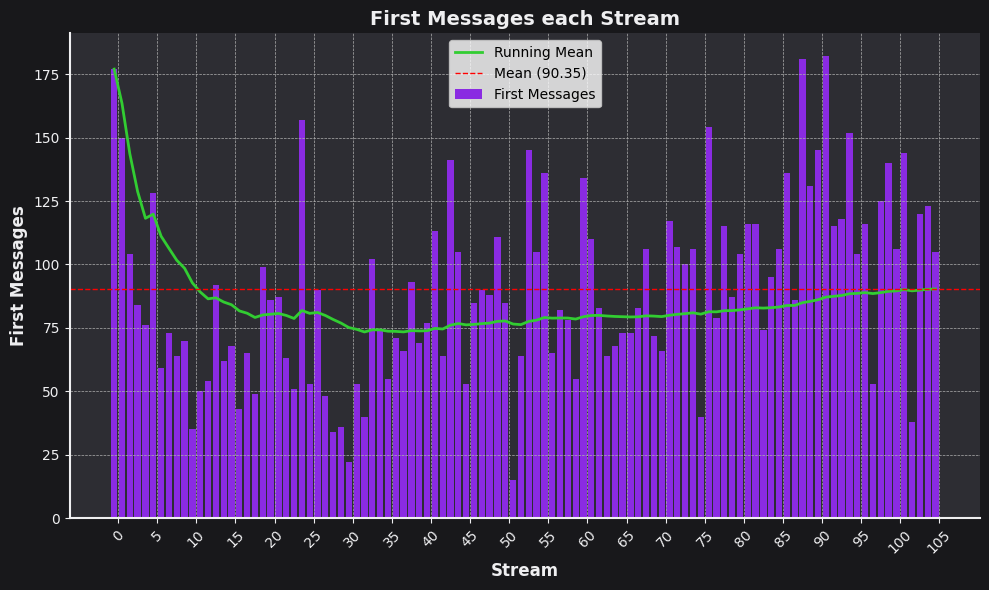

In [8]:
# Plot the chart
fig, ax = plt.subplots(figsize=(10, 6))

# Labels and title with custom color
label_color = '#EFEFF1'  # Color for the labels


# Bar plots
bar1 = ax.bar(index, stream_stats['first_messages'], color='#8A2BE2', alpha=1, label='First Messages')

# Plot the running mean line
ax.plot(index, stream_stats['first_messages_avg'], color='#32CD32', linestyle='-', linewidth=2, label='Running Mean')

# Draw the mean line
ax.axhline(mean_first_messages, color='r', linestyle='--', linewidth=1, label=f'Mean ({mean_first_messages:.2f})')

# Set the background color of the figure (entire plot area)
fig.patch.set_facecolor('#18181B')

# Labels and title
ax.set_xlabel('Stream', fontsize=12, fontweight='bold', color=label_color)
ax.set_ylabel('First Messages', fontsize=12, fontweight='bold', color=label_color)
ax.set_title('First Messages each Stream', fontsize=14, fontweight='bold', color=label_color)

# Customizing the plot background and axes spines
ax.set_facecolor('#2D2D33')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_color(label_color)
ax.spines['bottom'].set_color(label_color)

# Adjusting x-axis ticks and labels to show every 5th label
xticks = np.arange(0, len(index), 5)
ax.set_xticks([i +1 / 2 for i in xticks])
ax.set_xticklabels(stream_stats.index[xticks], fontsize=10, rotation=45, color=label_color)

# Adding grid
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Changing tick colors
ax.tick_params(axis='y', colors=label_color)
ax.tick_params(axis='x', colors=label_color)

# Add legend
ax.legend(fontsize=10)

plt.tight_layout()
plt.show()


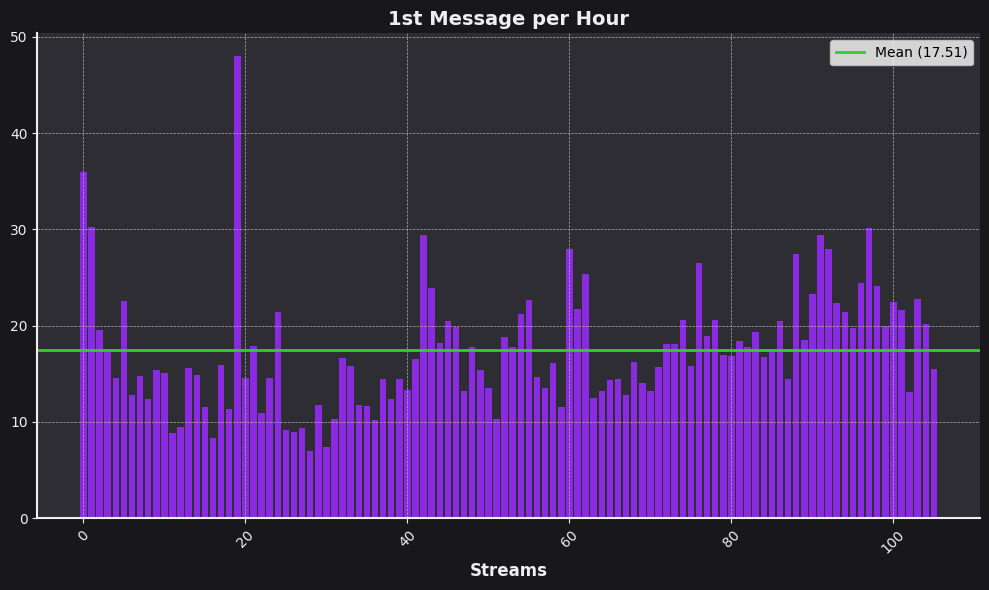

In [9]:
# Plot the chart with custom style
fig, ax = plt.subplots(figsize=(10, 6))  # Set figure size

# Bar plot for 'stream_length_per_first' with custom color and transparency
ax.bar(stream_stats.index, 
       stream_stats['stream_length_per_firt'], 
       color='#8A2BE2',  # Custom color for bars
       alpha=1           # Transparency  
      )
# Adding grid with custom style
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Calculate mean of first messages
mean_stream_length_per_firt = stream_stats['stream_length_per_firt'].mean()

# Draw the mean line with custom style
ax.axhline(mean_stream_length_per_firt, 
           color='#32CD32',          # Custom color for mean line
           linestyle='-',           # Line style
           linewidth=2,              # Line width
           label=f'Mean ({mean_stream_length_per_firt:.2f})'
          )

# Set the background color of the figure (entire plot area)
fig.patch.set_facecolor('#18181B')

# Labels and title with custom color
label_color = '#EFEFF1'  # Color for the labels
ax.set_xlabel('Streams', fontsize=12, fontweight='bold', color=label_color)
ax.set_title('1st Message per Hour', fontsize=14, fontweight='bold', color=label_color)


# Customizing the plot background and axes spines
ax.set_facecolor('#2D2D33')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_color(label_color)
ax.spines['bottom'].set_color(label_color)

# Rotating x-axis labels
plt.xticks(rotation=45, fontsize=10)

# Changing tick colors
ax.tick_params(axis='y', colors=label_color)
ax.tick_params(axis='x', colors=label_color)

# Add legend
ax.legend()

plt.tight_layout()
plt.show()


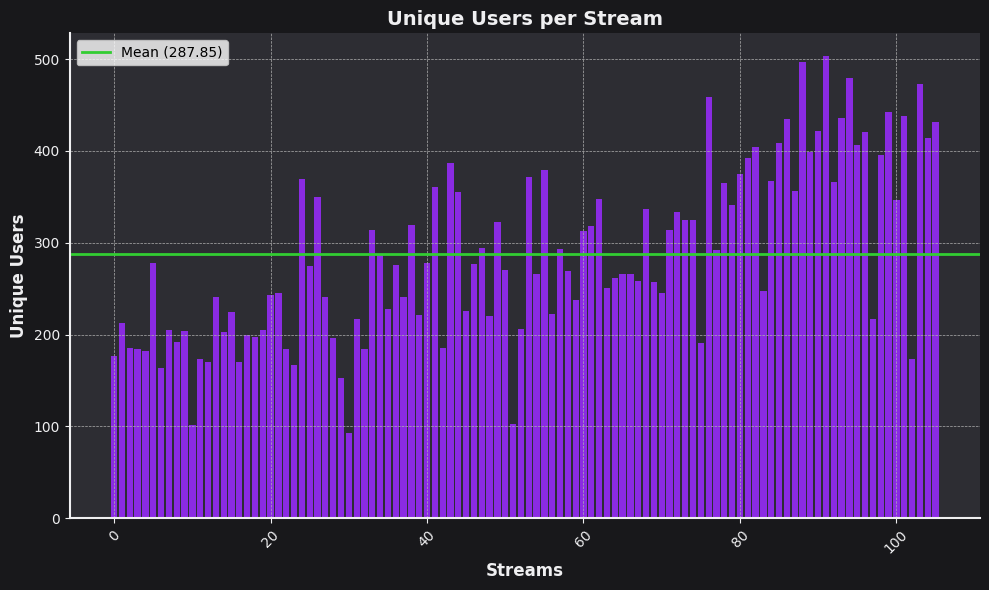

In [10]:
# Plot the chart with custom style
fig, ax = plt.subplots(figsize=(10, 6))  # Set figure size

# Bar plot for 'unique_chatters' with custom color and transparency
ax.bar(stream_stats.index, 
       stream_stats['unique_chatters'], 
       color='#8A2BE2',  # Custom color for bars
       alpha=1           # Transparency  
      )

# Calculate mean of unique chatters
mean_stream_unique = stream_stats['unique_chatters'].mean()

# Draw the mean line with custom style
ax.axhline(mean_stream_unique, 
           color='#32CD32',          # Custom color for mean line
           linestyle='-',           # Line style
           linewidth=2,              # Line width
           label=f'Mean ({mean_stream_unique:.2f})'
          )

# Set the background color of the figure (entire plot area)
fig.patch.set_facecolor('#18181B')

# Labels and title with custom color
label_color = '#EFEFF1'  # Color for the labels
ax.set_xlabel('Streams', fontsize=12, fontweight='bold', color=label_color)
ax.set_ylabel('Unique Users', fontsize=12, fontweight='bold', color=label_color)
ax.set_title('Unique Users per Stream', fontsize=14, fontweight='bold', color=label_color)

# Adding grid with custom style
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Customizing the plot background and axes spines
ax.set_facecolor('#2D2D33')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_color(label_color)
ax.spines['bottom'].set_color(label_color)

# Rotating x-axis labels
plt.xticks(rotation=45, fontsize=10)

# Changing tick colors
ax.tick_params(axis='y', colors=label_color)
ax.tick_params(axis='x', colors=label_color)

# Add legend
ax.legend()

plt.tight_layout()
plt.show()


In [11]:
# Calculate mean of first messages
stream_stats['unique_chatters_per_hour_avg'] = stream_stats['unique_chatters_per_hour'].expanding().mean()

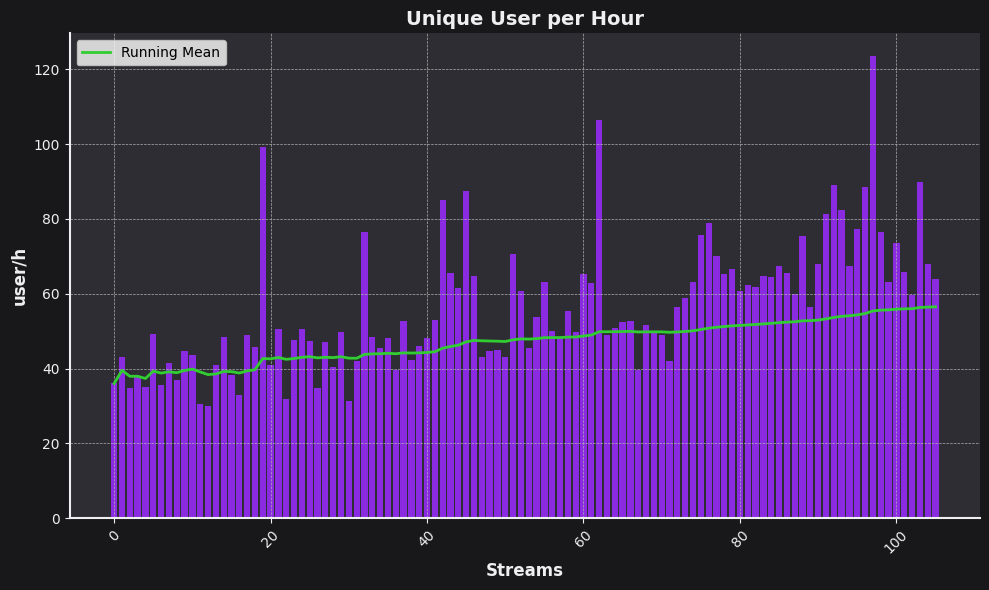

In [12]:

fig, ax = plt.subplots(figsize=(10, 6))  # Set figure size

# Labels and title with custom color
label_color = '#EFEFF1'  # Color for the labels

# Bar plot for 'unique_chatters_per_hour'
ax.bar(stream_stats.index, 
       stream_stats['unique_chatters_per_hour'], 
       color='#8A2BE2',  # Custom color for bars
       alpha=1      # Transparency  
      )

# Set the background color of the figure (entire plot area)
fig.patch.set_facecolor('#18181B')

# Plot the running mean line
ax.plot(stream_stats.index,  # Ensure this is correctly defined
        stream_stats['unique_chatters_per_hour_avg'], 
        color='#32CD32', 
        linestyle='-', 
        linewidth=2, 
        label='Running Mean'
       )

# Labels and title
ax.set_xlabel('Streams', fontsize=12, fontweight='bold', color=label_color)
ax.set_ylabel('user/h', fontsize=12, fontweight='bold', color=label_color)
ax.set_title('Unique User per Hour', fontsize=14, fontweight='bold', color=label_color)

# Adding grid
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Customizing the plot background and axes spines
ax.set_facecolor('#2D2D33')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_color(label_color)
ax.spines['bottom'].set_color(label_color)

# Rotating x-axis labels
plt.xticks(rotation=45, fontsize=10)

# Changing tick colors
ax.tick_params(axis='y', colors=label_color)
ax.tick_params(axis='x', colors=label_color)

# Add legend
ax.legend()

plt.tight_layout()
plt.show()


In [13]:
# Group by stream and aggregate users
stream_users = data.groupby('stream')['user'].apply(set).reset_index()
stream_users.columns = ['stream', 'users']

# Initialize columns for returning users and their count
stream_users['returning_users'] = [set()] * len(stream_users)
stream_users['returning_count'] = 0

# Loop through streams to identify returning users
for i in range(1, len(stream_users)):
    current_users = stream_users.at[i, 'users']
    previous_users = stream_users.at[i - 1, 'users']
    
    # Identify returning users
    returning_users = current_users.intersection(previous_users)
    
    # Update dataframe with returning users and their count
    stream_users.at[i, 'returning_users'] = returning_users
    stream_users.at[i, 'returning_count'] = len(returning_users)

In [14]:
stream_stats = pd.merge(stream_stats, stream_users, on='stream', how='right')

In [15]:
# Calculate mean of first messages
stream_stats['returning_count_avg'] = stream_stats['returning_count'].expanding().mean()

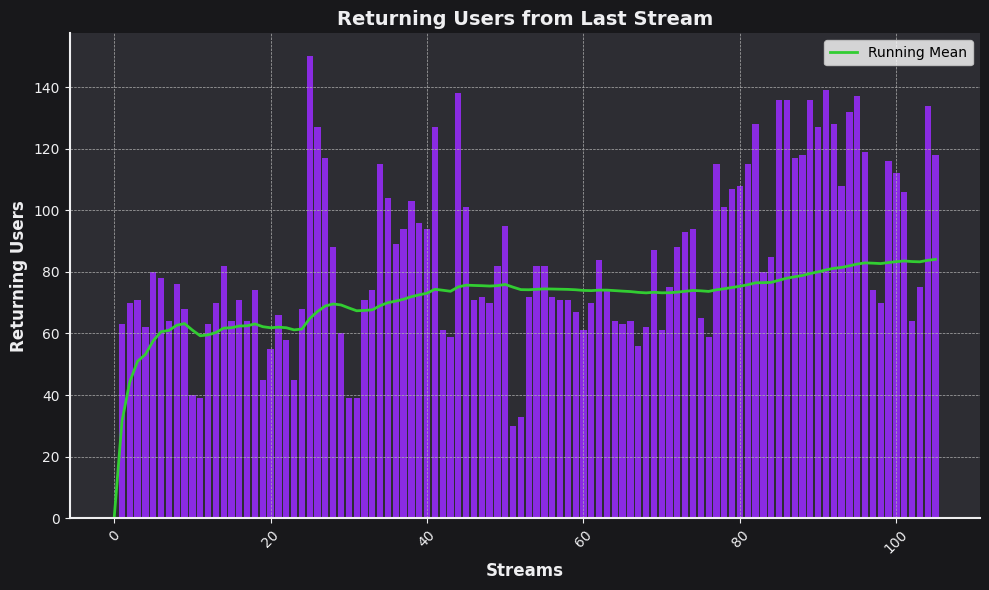

In [16]:
# Plot the chart with custom style
fig, ax = plt.subplots(figsize=(10, 6))  # Set figure size

# Bar plot for 'returning_count' with custom color and transparency
ax.bar(stream_stats.index, 
       stream_stats['returning_count'], 
       color='#8A2BE2',  # Custom color for bars
       alpha=1           # Transparency  
      )

# Plot the running mean line with custom style
ax.plot(stream_stats.index, 
        stream_stats['returning_count_avg'], 
        color='#32CD32',          # Custom color for running mean line
        linestyle='-',           # Line style
        linewidth=2,              # Line width
        label='Running Mean'
       )

# Set the background color of the figure (entire plot area)
fig.patch.set_facecolor('#18181B')

# Labels and title with custom color
label_color = '#EFEFF1'  # Color for the labels
ax.set_xlabel('Streams', fontsize=12, fontweight='bold', color=label_color)
ax.set_ylabel('Returning Users', fontsize=12, fontweight='bold', color=label_color)
ax.set_title('Returning Users from Last Stream', fontsize=14, fontweight='bold', color=label_color)

# Adding grid with custom style
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Customizing the plot background and axes spines
ax.set_facecolor('#2D2D33')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_color(label_color)
ax.spines['bottom'].set_color(label_color)

# Rotating x-axis labels
plt.xticks(rotation=45, fontsize=10)

# Changing tick colors
ax.tick_params(axis='y', colors=label_color)
ax.tick_params(axis='x', colors=label_color)

# Add legend
ax.legend()

plt.tight_layout()
plt.show()


In [17]:
# Create a new column for the first-time chatters by subtracting returning_count from unique_chatters
stream_stats['grouped_return_first'] = stream_stats['returning_count'] + stream_stats['first_messages']

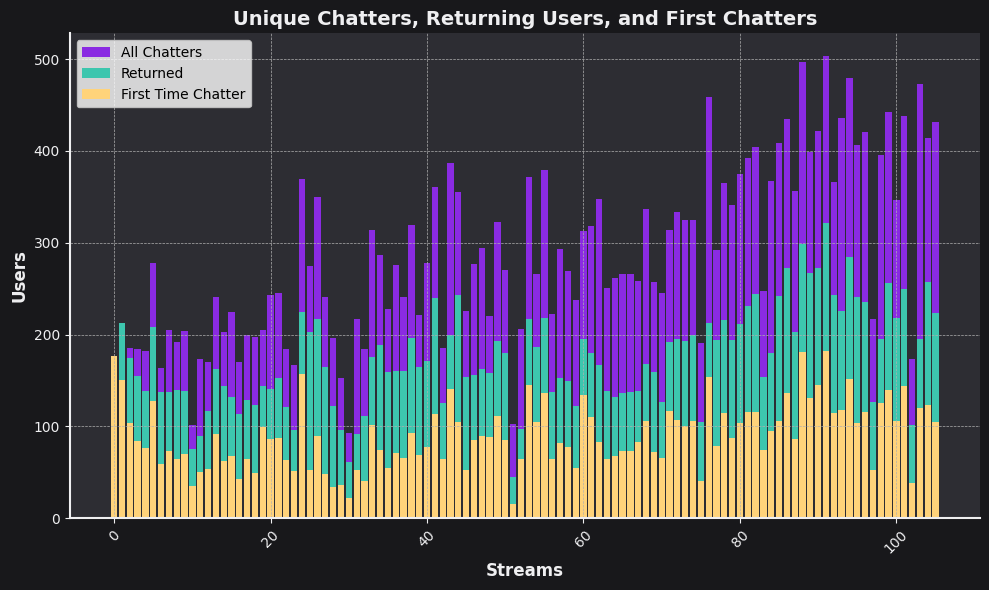

In [18]:
# Plot the bars with specified colors
fig, ax = plt.subplots(figsize=(10, 6))  # Set figure size

# Bar plot for all chatters (base layer)
ax.bar(stream_stats.index, 
       stream_stats['unique_chatters'], 
       label='All Chatters', 
       color='#8A2BE2',  # Custom color for the first set of bars (purple)
       alpha=1           # Transparency
      )

# Bar plot for returning users (stacked on top)
ax.bar(stream_stats.index, 
       stream_stats['grouped_return_first'], 
       label='Returned', 
       color='#3DC6AE',  # Custom color for the second set of bars
       alpha=1           # Transparency
      )

# Bar plot for first-time chatters (stacked on top)
ax.bar(stream_stats.index, 
       stream_stats['first_messages'], 
       label='First Time Chatter', 
       color='#FFD37A',  # Custom color for the third set of bars
       alpha=1           # Transparency
      )

# Set the background color of the figure (entire plot area)
fig.patch.set_facecolor('#18181B')

# Labels and title with custom color
label_color = '#EFEFF1'  # Color for the labels
ax.set_xlabel('Streams', fontsize=12, fontweight='bold', color=label_color)
ax.set_ylabel('Users', fontsize=12, fontweight='bold', color=label_color)
ax.set_title('Unique Chatters, Returning Users, and First Chatters', fontsize=14, fontweight='bold', color=label_color)

# Customizing the plot background and axes spines
ax.set_facecolor('#2D2D33')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_color(label_color)
ax.spines['bottom'].set_color(label_color)

# Adding legend to differentiate the bars
ax.legend()

# Rotating x-axis labels
plt.xticks(rotation=45, fontsize=10)

# Changing tick colors
ax.tick_params(axis='y', colors=label_color)
ax.tick_params(axis='x', colors=label_color)

# Adding grid with custom style
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Display the plot
plt.tight_layout()
plt.show()


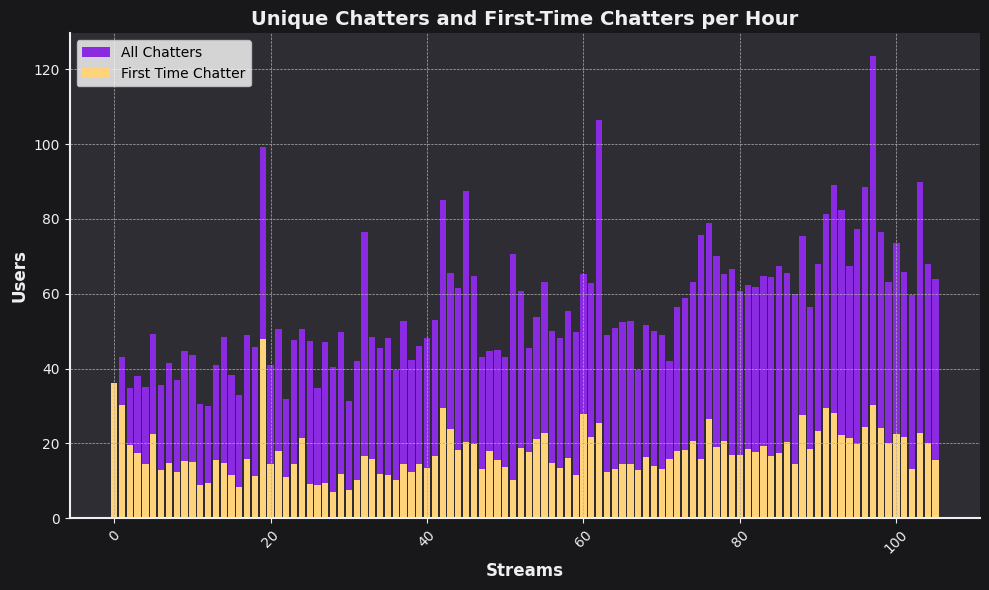

In [19]:
# Plot the bars with specified colors
fig, ax = plt.subplots(figsize=(10, 6))  # Set figure size

# Bar plot for all chatters
ax.bar(stream_stats.index, 
       stream_stats['unique_chatters_per_hour'], 
       label='All Chatters', 
       color='#8A2BE2',  # Custom color for the first set of bars (purple)
       alpha=1           # Transparency
      )

# Bar plot for first-time chatters (stacked on top)
ax.bar(stream_stats.index, 
       stream_stats['stream_length_per_firt'], 
       label='First Time Chatter', 
       color='#FFD37A',  # Custom color for the second set of bars (yellow)
       alpha=1           # Transparency
      )

# Set the background color of the figure (entire plot area)
fig.patch.set_facecolor('#18181B')

# Labels and title with custom color
label_color = '#EFEFF1'  # Color for the labels
ax.set_xlabel('Streams', fontsize=12, fontweight='bold', color=label_color)
ax.set_ylabel('Users', fontsize=12, fontweight='bold', color=label_color)
ax.set_title('Unique Chatters and First-Time Chatters per Hour', fontsize=14, fontweight='bold', color=label_color)

# Customizing the plot background and axes spines
ax.set_facecolor('#2D2D33')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_color(label_color)
ax.spines['bottom'].set_color(label_color)

# Adding legend to differentiate the bars
ax.legend()

# Rotating x-axis labels
plt.xticks(rotation=45, fontsize=10)

# Changing tick colors
ax.tick_params(axis='y', colors=label_color)
ax.tick_params(axis='x', colors=label_color)

# Adding grid with custom style
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Display the plot
plt.tight_layout()
plt.show()


In [20]:
# Path to your Excel file
file_path = 'DorozeaStreamStats.xlsx'

# Reading a specific sheet with custom column names and skipping the first two rows
exelStats = pd.read_excel(file_path, sheet_name='Munkalap1', header=None, names=['stream', 'avg', 'max','follow','games'], skiprows=1)

# Display the DataFrame
exelStats.head(2)

,stream,avg,max,follow,games
0,0,129,145,9,"jc, cs, valo, ow2, marbels"
1,1,152,290,24,"jc, cs, ow2, marbels"


In [21]:
stream_stats = pd.merge(stream_stats, exelStats, on='stream', how='right')


In [22]:
stream_stats.tail(3)

,stream,first_messages,total_messages,unique_chatters,stream_length,stream_length_hour,stream_length_per_firt,unique_chatters_per_hour,first_messages_avg,unique_chatters_per_hour_avg,users,returning_users,returning_count,returning_count_avg,grouped_return_first,avg,max,follow,games
103,103,120,4340,473,18962.0,5.267222,22.782407,89.800654,89.894231,56.318060,"{jakan___, cykodarkpsy, Everest_89, xHuseyinG,...","{enigmaticr1, Andiells, jakan___, blind_dood, ...",75,83.278846,195,285,347,84,"jc, cs, marbels"
104,104,123,3316,414,21930.0,6.091667,20.191518,67.961696,90.209524,56.428952,"{jakan___, Rykard__, Qusay_b, supperclip, deyz...","{charlypizzas, Crazy_Kier, jakan___, prosunbyb...",134,83.761905,257,210,289,71,"jc, ow2, lol, cs"
105,105,105,5262,432,24320.0,6.755556,15.542763,63.947368,90.349057,56.499881,"{zataa11, yeleny12, mustang1badshah, 0SAMAH, 8...","{gl0st01, cazzperxddd420, Djang0o_, Aloddin, I...",118,84.084906,223,267,334,64,"jc, er, codbo6"


In [23]:
#user with only 1 messege

# 1. Group by stream and user, and count the number of messages per user in each stream
user_message_counts = data.groupby(['stream', 'user']).size().reset_index(name='message_count')

# 2. Filter to keep only users who sent exactly one message in a stream
one_message_users = user_message_counts[user_message_counts['message_count'] == 1]

# 3. Count the number of such users for each stream
one_message_user_counts = one_message_users.groupby('stream').size().reset_index(name='one_message_user_count')

# 4. Merge this new information into the stream_stats dataframe
stream_stats = stream_stats.merge(one_message_user_counts, on='stream', how='left')

In [24]:
#2 or more messeges
stream_stats['two_or_more_message_user_counts'] = stream_stats['unique_chatters'] - stream_stats['one_message_user_count']

In [25]:
#message per chater
stream_stats['message_per_chater'] = stream_stats['total_messages'] / stream_stats['unique_chatters']

In [26]:
#hours watched
stream_stats['hours_watched'] = stream_stats['stream_length_hour'] * stream_stats['avg']

In [27]:
#total words count

# 1. Calculate the word count for each message
data['word_count'] = data['message'].apply(lambda x: len(x.split()))

# 2. Sum the word counts for each stream
stream_word_counts = data.groupby('stream')['word_count'].sum().reset_index(name='total_word_count')

# 3. Merge this new information into the stream_stats dataframe
stream_stats = stream_stats.merge(stream_word_counts, on='stream', how='left')

# If there are streams without any messages, fill NaN with 0
stream_stats['total_word_count'] = stream_stats['total_word_count'].fillna(0).astype(int)

In [28]:
#messege/min
stream_stats['message_per_min'] = stream_stats['total_messages'] / stream_stats['stream_length_hour'] / 60


In [29]:
#No stream elements
dataNoBots = data[data['user'] != 'StreamElements']

In [30]:
# 1. Count the number of messages per user in each stream
user_message_counts = dataNoBots.groupby(['stream', 'user']).size().reset_index(name='message_count')

# 2. Find the top 5 users for each stream
top_5_users = user_message_counts.groupby('stream').apply(
    lambda x: x.nlargest(5, 'message_count')['user'].tolist()
).reset_index(name='top_5_users')

# Convert the list to a comma-separated string for easier viewing
top_5_users['top_5_users'] = top_5_users['top_5_users'].apply(lambda x: ', '.join(x))

# 3. Merge this information into the stream_stats dataframe
stream_stats = stream_stats.merge(top_5_users[['stream', 'top_5_users']], on='stream', how='left')



C:\Users\Kardo\AppData\Local\Temp\ipykernel_4448\877315785.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_5_users = user_message_counts.groupby('stream').apply(


In [31]:
for entry in stream_stats['top_5_users']:
    print(entry)

Martin_Gales, Banties1g, Jello_CS, 1206paul_, Wii_Gii
Martin_Gales, saykokerem, klimzaa, LX212, Banties1g
Banties1g, Martin_Gales, klimzaa, LX212, Wii_Gii
Martin_Gales, Banties1g, LX212, roxa0, zaxkyyy_
Martin_Gales, klimzaa, x3lolx, ylb_cat_soul22, Banties1g
Martin_Gales, roxa0, Banties1g, IvanOnMyOwn, Risc__V
Martin_Gales, klimzaa, IvanOnMyOwn, peroni_nasturo_azuro, Risc__V
Martin_Gales, Banties1g, ylb_cat_soul22, Risc__V, 1SKELTON
Martin_Gales, Dmoz1, klimzaa, roxa0, Banties1g
oJov, roxa0, Ivana_10, IvanOnMyOwn, Martin_Gales
1SKELTON, zaxkyyy_, klimzaa, LX212, Banties1g
Martin_Gales, Banties1g, oJov, Typhu25, Krompus
LX212, amirmasoud_2018, 1SKELTON, klimzaa, Banties1g
oJov, Banties1g, klimzaa, LX212, abeKrd
Banties1g, oJov, LX212, 1SKELTON, IvanOnMyOwn
Martin_Gales, Dmoz1, I_Yovan_I, IvanOnMyOwn, LX212
Martin_Gales, sekasekas, ylb_cat_soul22, Banties1g, I_Yovan_I
oJov, Banties1g, Martin_Gales, sekasekas, IvanOnMyOwn
Martin_Gales, oJov, IvanOnMyOwn, roxa0, Dmoz1
Martin_Gales, roxa0,

In [32]:
#top 5 word in chat


# Define the list of words to exclude
stop_words = {'the',
                'a',
                'is',
                'to',
                'and',
                'i',
                'you',
                'in',
                'it',
                'u',
                'for',
                ']',
                'so',
                'on',
                'my',
                'are',
                'of',
                'this',
                'they',
                '/',
                'like',
                'have',
                'that',
                'its',
                '?',
                '!',
                'but',
                #maybe not
                'just',
                'was',
                'what',
                'your',
                'can',
                'not',
                'if',
                'she',
                'him',
                'we',
                'they',
                'at',
                'from',
                'by',
                'be',
                'he',
                'do'
                }

# 1. Tokenize messages by splitting them into words
#data['words'] = data['message'].apply(lambda x: x.split())

# Tokenize messages, splitting into words and filtering out stop words
dataNoBots = dataNoBots.copy()
dataNoBots['words'] = dataNoBots['message'].apply(lambda x: [word for word in x.split() if word.lower() not in stop_words])


# 2. Aggregate all words per stream
stream_words = dataNoBots.groupby('stream')['words'].sum().reset_index()

# 3. Calculate the top 5 most common words for each stream
stream_words['top_5_words'] = stream_words['words'].apply(lambda x: [word for word, count in Counter(x).most_common(5)])

# Convert list to a comma-separated string for easier viewing
stream_words['top_5_words'] = stream_words['top_5_words'].apply(lambda x: ', '.join(x))

# 4. Merge this information into the stream_stats dataframe
stream_stats = stream_stats.merge(stream_words[['stream', 'top_5_words']], on='stream', how='left')


In [33]:
stream_stats['top_5_words'].tail(3)

103    !play, doro, with, no, play
104       play, me, with, doro, no
105     WW, looks, with, good, eat
Name: top_5_words, dtype: object

In [34]:
for entry in stream_stats['top_5_words']:
    print(entry)

1, doro, !play, with, good
sigma, doro, !play, mhm, with
mhm, !play, omE, doro, good
!play, mhm, doro, omE, LUL
mhm, doro, with, good, O?
mhm, setup, omE, !play, no
mhm, !play, peroni, doro, with
doro, mhm, with, me, when
peroni, !play, doro, mhm, no
LITHUANIA, good, song, no, #N1
LUL, mhm, how, omE, no
mhm, doro, no, game, omE
xd, !play, LUL, rameeKEK, omE
omE, hu, rameeKEK, with, !play
happy, happi, :D, am, !play
with, no, doro, good, yes
good, doro, mhm, with, play
doro, omE, with, raid, LUL
mhm, doro, with, good, cult
dimacut, RAID, raid, 󠀀, mhm
tier, mhm, good, with, omE
good, with, dont, tier, S
gkeyL, rameeKEK, raid, gamily, 100k
!play, doro, play, no, AIMindControlAttempt3
will, got, doro, no, omE
mhm, no, go, with, game
chair, mhm, doro, !play, no
@1206paul_, doro, mhm, good, with
PepeLaugh, no, mhm, doro, go
doro, K?, mhm, @1206paul_, im
TriHard, LETSGO, omE, doro, gg
bye, doro, mhm, good, her
doro, ding, play, up, LUL
dimacut, RAID, boss, Prayge, no
EZ, WW, gg, no, go
go, no

In [35]:
subData = data[data.apply(lambda row: row['user'].lower() in row['message'].lower(), axis=1)]
giftedData = subData[subData['message'].str.contains(' sub ', case=False, na=False)]

unique_gifter = giftedData['user'].nunique()
print("Number of unique users:", unique_gifter)

Number of unique users: 90


In [36]:
unique_users_per_stream = giftedData.groupby('stream')['user'].nunique()

stream_stats = pd.merge(stream_stats, unique_users_per_stream, on='stream', how='left')

stream_stats = stream_stats.rename(columns={'user': 'gifter'})
stream_stats['gifter'] = stream_stats['gifter'].fillna(0)

In [37]:
stream_stats['gifter'].describe()

count    106.000000
mean       1.500000
std        1.325573
min        0.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        6.000000
Name: gifter, dtype: float64

In [38]:
gift_per_stream = giftedData.groupby('stream')['user'].count()

stream_stats = pd.merge(stream_stats, gift_per_stream, on='stream', how='left')

stream_stats = stream_stats.rename(columns={'user': 'gift'})
stream_stats['gift'] = stream_stats['gift'].fillna(0)

In [39]:
raids = subData[subData['message'].str.contains(' raiders from ', case=False, na=False)].copy()
raids['raid'] = raids['message'].str.split().str[0]
raids['raid'] = pd.to_numeric(raids['raid'], errors='raise')

raid_stream = raids.groupby('stream')['raid'].max()
stream_stats = pd.merge(stream_stats, raid_stream, on='stream', how='left')
stream_stats['raid'] = stream_stats['raid'].fillna(0)


stream_stats['raid'].head(5)

0      4.0
1    125.0
2      0.0
3      0.0
4      0.0
Name: raid, dtype: float64

In [40]:
stream_stats['raid'].tail(5)

101    22.0
102    26.0
103    14.0
104     0.0
105     0.0
Name: raid, dtype: float64

In [41]:
raids.sort_values(by='stream').tail(5)

,date,user,message,stream,first_message,word_count,raid
305146,2024-08-31 16:52:57+00:00,gkey,208 raiders from gkey have joined!,99,0,6,208
308848,2024-09-02 10:46:51+00:00,Obafemimoebus,13 raiders from Obafemimoebus have joined!,101,0,6,13
310390,2024-09-02 14:08:01+00:00,Obafemimoebus,22 raiders from Obafemimoebus have joined!,101,0,6,22
312901,2024-09-03 18:08:57+00:00,JanEmmel,26 raiders from JanEmmel have joined!,102,1,6,26
313721,2024-09-04 12:42:50+00:00,Obafemimoebus,14 raiders from Obafemimoebus have joined!,103,0,6,14


In [42]:
primeData = subData[subData['message'].str.contains('Prime', case=False, na=False)]

prime_per_stream = primeData.groupby('stream')['user'].count()

stream_stats = pd.merge(stream_stats, prime_per_stream, on='stream', how='left')
stream_stats = stream_stats.rename(columns={'user': 'prime'})
stream_stats['prime'] = stream_stats['prime'].fillna(0)

#stream_stats['prime'].describe()
stream_stats.head(5)


,stream,first_messages,total_messages,unique_chatters,stream_length,stream_length_hour,stream_length_per_firt,unique_chatters_per_hour,first_messages_avg,unique_chatters_per_hour_avg,...,message_per_chater,hours_watched,total_word_count,message_per_min,top_5_users,top_5_words,gifter,gift,raid,prime
0,0,177,1985,177,17697.0,4.915833,36.006103,36.006103,177.000000,36.006103,...,11.214689,634.142500,10568,6.729954,"Martin_Gales, Banties1g, Jello_CS, 1206paul_, ...","1, doro, !play, with, good",4.0,25.0,4.0,2.0
1,1,150,3046,213,17831.0,4.953056,30.284336,43.003758,163.500000,39.504930,...,14.300469,752.864444,14301,10.249565,"Martin_Gales, saykokerem, klimzaa, LX212, Bant...","sigma, doro, !play, mhm, with",4.0,31.0,125.0,1.0
2,2,104,2754,185,19147.0,5.318611,19.553977,34.783517,143.666667,37.931126,...,14.886486,670.145000,13389,8.630073,"Banties1g, Martin_Gales, klimzaa, LX212, Wii_Gii","mhm, !play, omE, doro, good",0.0,0.0,0.0,2.0
3,3,84,2375,184,17451.0,4.847500,17.328520,37.957710,128.750000,37.937772,...,12.907609,644.717500,10244,8.165721,"Martin_Gales, Banties1g, LX212, roxa0, zaxkyyy_","!play, mhm, doro, omE, LUL",2.0,6.0,0.0,1.0
4,4,76,2455,182,18734.0,5.203889,14.604462,34.973844,118.200000,37.344986,...,13.489011,770.175556,11883,7.862710,"Martin_Gales, klimzaa, x3lolx, ylb_cat_soul22,...","mhm, doro, with, good, O?",0.0,0.0,0.0,2.0


In [43]:
trueSub =  subData[~ subData['message'].str.contains('Prime', case=False, na=False)]

trueSub = trueSub[~trueSub['message'].str.contains('raiders', case=False, na=False)]

trueSub = trueSub[~trueSub['message'].str.contains('gifting', case=False, na=False)]

trueSub = trueSub[~trueSub['message'].str.contains('gifted', case=False, na=False)]

trueSub = trueSub[trueSub['message'].str.contains(' subscribed at ', case=False, na=False)]



tier1 = trueSub[trueSub['message'].str.contains('Tier 1', case=False, na=False)]
tier2 = trueSub[trueSub['message'].str.contains('Tier 2', case=False, na=False)]
tier3 = trueSub[trueSub['message'].str.contains('Tier 3', case=False, na=False)]

tier1_per_stream = tier1.groupby('stream')['user'].count()
stream_stats = pd.merge(stream_stats, tier1_per_stream, on='stream', how='left')
stream_stats = stream_stats.rename(columns={'user': 'tier1'})
stream_stats['tier1'] = stream_stats['tier1'].fillna(0)

tier2_per_stream = tier2.groupby('stream')['user'].count()
stream_stats = pd.merge(stream_stats, tier2_per_stream, on='stream', how='left')
stream_stats = stream_stats.rename(columns={'user': 'tier2'})
stream_stats['tier2'] = stream_stats['tier2'].fillna(0)

tier3_per_stream = tier3.groupby('stream')['user'].count()
stream_stats = pd.merge(stream_stats, tier3_per_stream, on='stream', how='left')
stream_stats = stream_stats.rename(columns={'user': 'tier3'})
stream_stats['tier3'] = stream_stats['tier3'].fillna(0)


In [44]:
no_raid = stream_stats[stream_stats['raid']==0][['stream','avg', 'max']].copy()

In [45]:
no_raid.head(5)

,stream,avg,max
2,2,126,161
3,3,133,169
4,4,148,177
5,5,187,252
6,6,127,157


In [46]:

no_raid['per'] = (no_raid['max'] / no_raid['avg']) *100

correct_per = no_raid['per'].mean

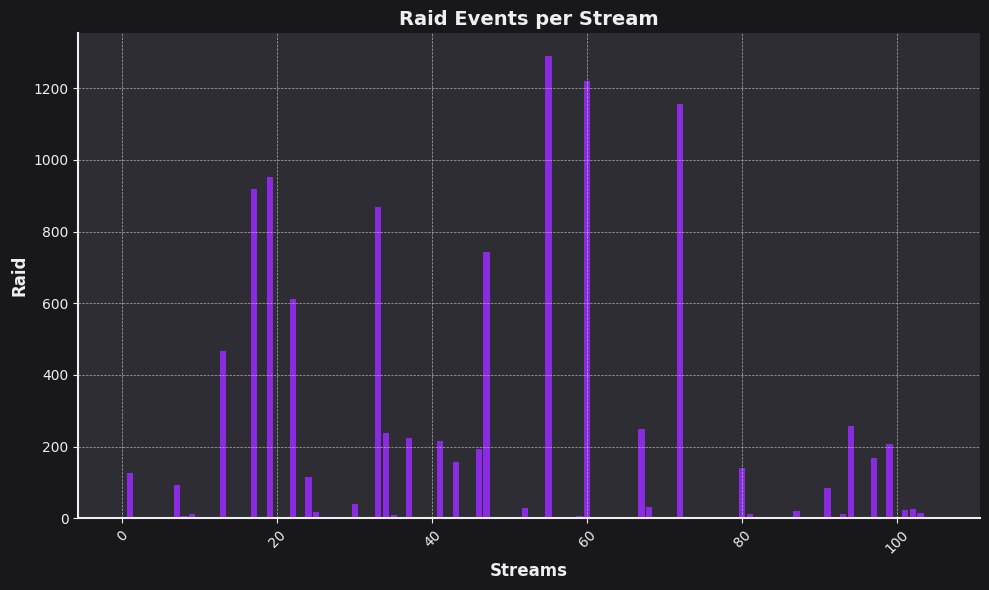

In [47]:
# Plot the bar chart with custom styling
fig, ax = plt.subplots(figsize=(10, 6))  # Set figure size

# Bar plot for raid
ax.bar(stream_stats.index, 
       stream_stats['raid'], 
       color='#8A2BE2',  # Custom color for bars (purple)
       alpha=1           # Transparency
      )

# Set the background color of the figure (entire plot area)
fig.patch.set_facecolor('#18181B')

# Labels and title with custom color
label_color = '#EFEFF1'  # Color for the labels
ax.set_xlabel('Streams', fontsize=12, fontweight='bold', color=label_color)
ax.set_ylabel('Raid', fontsize=12, fontweight='bold', color=label_color)
ax.set_title('Raid Events per Stream', fontsize=14, fontweight='bold', color=label_color)

# Customizing the plot background and axes spines
ax.set_facecolor('#2D2D33')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_color(label_color)
ax.spines['bottom'].set_color(label_color)

# Rotating x-axis labels
plt.xticks(rotation=45, fontsize=10, color=label_color)

# Changing tick colors
ax.tick_params(axis='y', colors=label_color)
ax.tick_params(axis='x', colors=label_color)

# Adding grid with custom style
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Display the plot
plt.tight_layout()
plt.show()


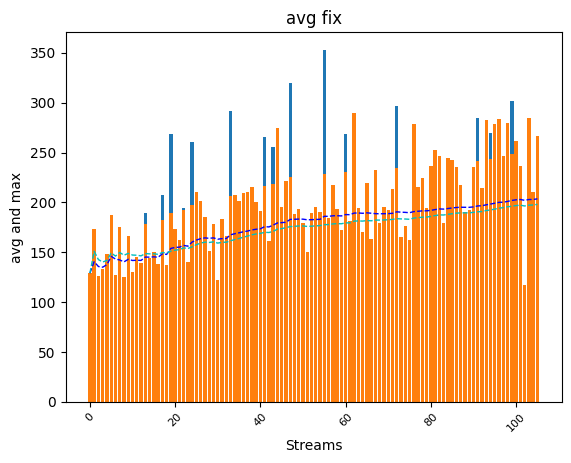

In [48]:
#fix

stream_stats['expanding_avg'] = stream_stats['avg'].expanding().mean()

stream_stats['avg_fix'] = stream_stats.apply(
    lambda row: row['expanding_avg'] * 1.23 if row['raid'] >= 50 else row['avg'], axis=1
)

fig, ax = plt.subplots()

ax.bar(stream_stats.index, stream_stats['avg'])

ax.bar(stream_stats.index, stream_stats['avg_fix'])

stream_stats['expanding_avg_fix'] = stream_stats['avg_fix'].expanding().mean()

ax.plot(index, stream_stats['expanding_avg'], color='b', linestyle='--', linewidth=1, label='Running Mean')
ax.plot(index, stream_stats['expanding_avg_fix'], color='c', linestyle='--', linewidth=1, label='Running Mean')

ax.set_xlabel('Streams', fontsize=10)
ax.set_ylabel('avg and max', fontsize=10)
ax.set_title('avg fix', fontsize=12)

plt.xticks(rotation=45, fontsize=8)
plt.show()

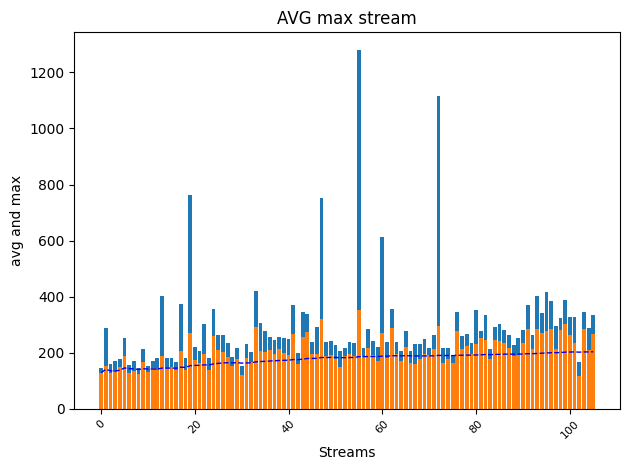

In [49]:
# Plot the chart
fig, ax = plt.subplots()

# Bar plot for max viever
ax.bar(stream_stats.index, stream_stats['max'])

# Bar plot for abg viever
ax.bar(stream_stats.index, stream_stats['avg'])

stream_stats['epanding_avg'] = stream_stats['avg'].expanding().mean()
# Plot the running mean line
ax.plot(index, stream_stats['epanding_avg'], color='b', linestyle='--', linewidth=1, label='Running Mean')

# Labels and title
ax.set_xlabel('Streams', fontsize=10)
ax.set_ylabel('avg and max', fontsize=10)
ax.set_title('AVG max stream', fontsize=12)

# Display the plot
plt.xticks(rotation=45, fontsize=8)  # Rotate x labels if necessary
plt.tight_layout()
plt.show()

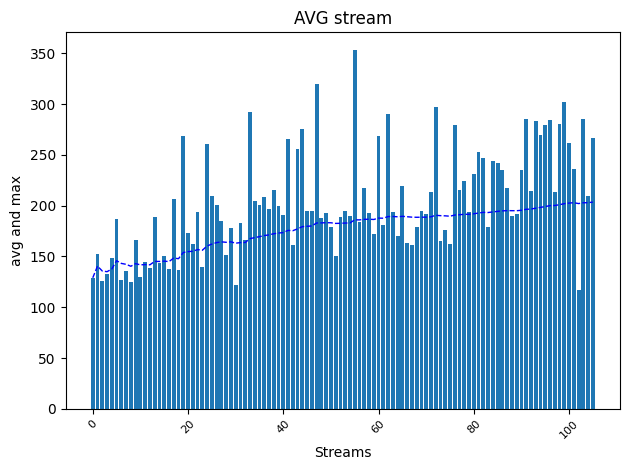

In [50]:
# Plot the chart
fig, ax = plt.subplots()

# Bar plot for abg viever
ax.bar(stream_stats.index, stream_stats['avg'])

# Plot the running mean line
ax.plot(index, stream_stats['epanding_avg'], color='b', linestyle='--', linewidth=1, label='Running Mean')

# Labels and title
ax.set_xlabel('Streams', fontsize=10)
ax.set_ylabel('avg and max', fontsize=10)
ax.set_title('AVG stream', fontsize=12)

# Display the plot
plt.xticks(rotation=45, fontsize=8)  # Rotate x labels if necessary
plt.tight_layout()
plt.show()

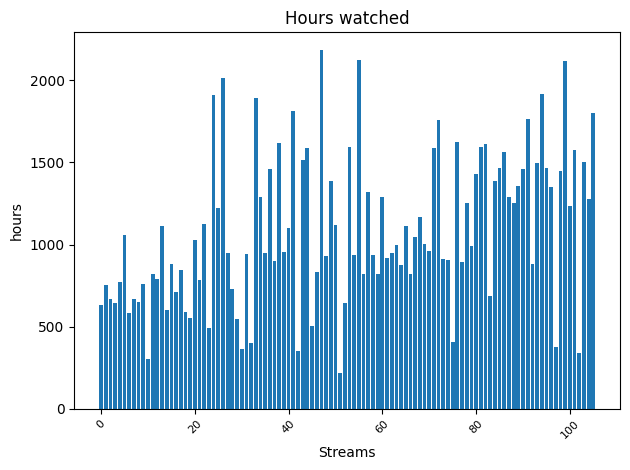

In [51]:
# Plot the chart
fig, ax = plt.subplots()

# Bar plot for abg viever
ax.bar(stream_stats.index, stream_stats['hours_watched'])

# Labels and title
ax.set_xlabel('Streams', fontsize=10)
ax.set_ylabel('hours', fontsize=10)
ax.set_title('Hours watched', fontsize=12)

# Display the plot
plt.xticks(rotation=45, fontsize=8)  # Rotate x labels if necessary
plt.tight_layout()
plt.show()

In [52]:
stream_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106 entries, 0 to 105
Data columns (total 38 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   stream                           106 non-null    int64  
 1   first_messages                   106 non-null    int64  
 2   total_messages                   106 non-null    int64  
 3   unique_chatters                  106 non-null    int64  
 4   stream_length                    106 non-null    float64
 5   stream_length_hour               106 non-null    float64
 6   stream_length_per_firt           106 non-null    float64
 7   unique_chatters_per_hour         106 non-null    float64
 8   first_messages_avg               106 non-null    float64
 9   unique_chatters_per_hour_avg     106 non-null    float64
 10  users                            106 non-null    object 
 11  returning_users                  106 non-null    object 
 12  returning_count       

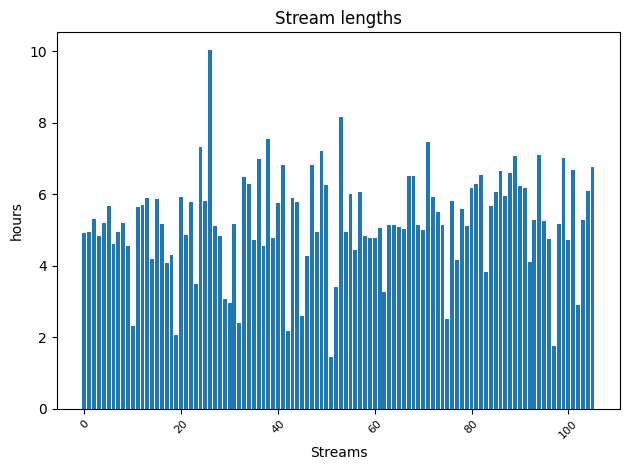

In [53]:
# Plot the chart
fig, ax = plt.subplots()

# Bar plot for abg viever
ax.bar(stream_stats.index, stream_stats['stream_length_hour'])

# Labels and title
ax.set_xlabel('Streams', fontsize=10)
ax.set_ylabel('hours', fontsize=10)
ax.set_title('Stream lengths', fontsize=12)

# Display the plot
plt.xticks(rotation=45, fontsize=8)  # Rotate x labels if necessary
plt.tight_layout()
plt.show()

In [54]:

stream_stats.head(2)

,stream,first_messages,total_messages,unique_chatters,stream_length,stream_length_hour,stream_length_per_firt,unique_chatters_per_hour,first_messages_avg,unique_chatters_per_hour_avg,...,gift,raid,prime,tier1,tier2,tier3,expanding_avg,avg_fix,expanding_avg_fix,epanding_avg
0,0,177,1985,177,17697.0,4.915833,36.006103,36.006103,177.0,36.006103,...,25.0,4.0,2.0,3.0,0.0,0.0,129.0,129.000,129.0000,129.0
1,1,150,3046,213,17831.0,4.953056,30.284336,43.003758,163.5,39.504930,...,31.0,125.0,1.0,1.0,0.0,0.0,140.5,172.815,150.9075,140.5


In [55]:
stream_stats.tail(2)

,stream,first_messages,total_messages,unique_chatters,stream_length,stream_length_hour,stream_length_per_firt,unique_chatters_per_hour,first_messages_avg,unique_chatters_per_hour_avg,...,gift,raid,prime,tier1,tier2,tier3,expanding_avg,avg_fix,expanding_avg_fix,epanding_avg
104,104,123,3316,414,21930.0,6.091667,20.191518,67.961696,90.209524,56.428952,...,20.0,0.0,5.0,5.0,0.0,0.0,202.923810,210.0,197.352403,202.923810
105,105,105,5262,432,24320.0,6.755556,15.542763,63.947368,90.349057,56.499881,...,2.0,0.0,3.0,2.0,0.0,0.0,203.528302,267.0,198.009456,203.528302


In [56]:
#stream_stats.to_csv('combined_output.csv', index=False)

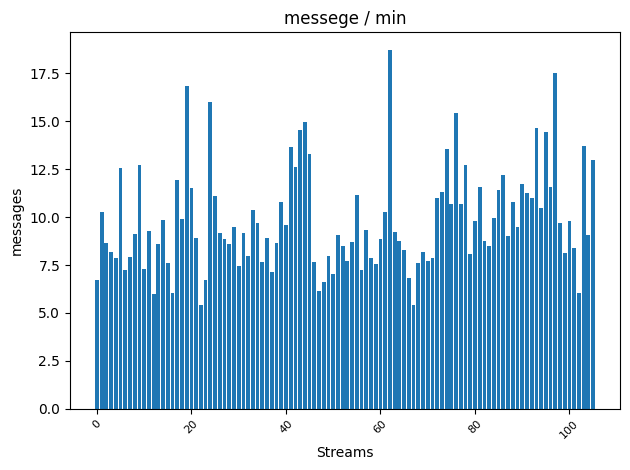

In [57]:
# Plot the chart
fig, ax = plt.subplots()

# Bar plot for max viever
ax.bar(stream_stats.index, stream_stats['message_per_min'])

# Labels and title
ax.set_xlabel('Streams', fontsize=10)
ax.set_ylabel('messages', fontsize=10)
ax.set_title('messege / min', fontsize=12)

# Display the plot
plt.xticks(rotation=45, fontsize=8)  # Rotate x labels if necessary
plt.tight_layout()
plt.show()

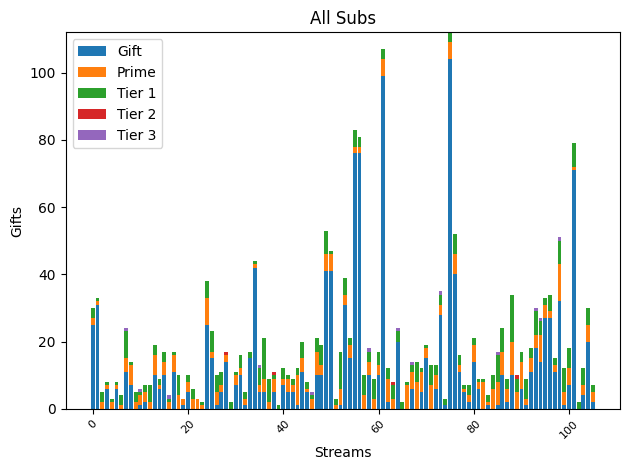

In [58]:
import matplotlib.pyplot as plt

# Plot the chart
fig, ax = plt.subplots()

# Stacked bar plot
ax.bar(stream_stats.index, stream_stats['gift'], label='Gift')
ax.bar(stream_stats.index, stream_stats['prime'], bottom=stream_stats['gift'], label='Prime')
ax.bar(stream_stats.index, stream_stats['tier1'], bottom=stream_stats['gift'] + stream_stats['prime'], label='Tier 1')
ax.bar(stream_stats.index, stream_stats['tier2'], bottom=stream_stats['gift'] + stream_stats['prime'] + stream_stats['tier1'], label='Tier 2')
ax.bar(stream_stats.index, stream_stats['tier3'], bottom=stream_stats['gift'] + stream_stats['prime'] + stream_stats['tier1'] + stream_stats['tier2'], label='Tier 3')

# Labels and title
ax.set_xlabel('Streams', fontsize=10)
ax.set_ylabel('Gifts', fontsize=10)
ax.set_title('All Subs', fontsize=12)

# Adding legend to differentiate the bars
ax.legend()

# Display the plot
plt.xticks(rotation=45, fontsize=8)  # Rotate x labels if necessary
plt.tight_layout()
plt.show()


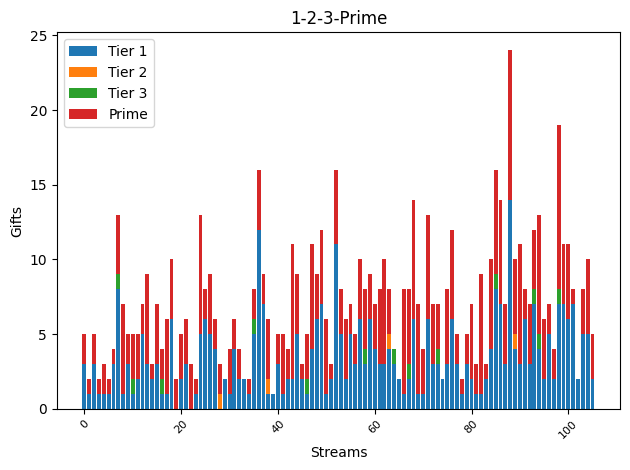

In [59]:
# Plot the chart
fig, ax = plt.subplots()

# Stacked bar plot
ax.bar(stream_stats.index, stream_stats['tier1'], label='Tier 1')
ax.bar(stream_stats.index, stream_stats['tier2'], bottom=stream_stats['tier1'], label='Tier 2')
ax.bar(stream_stats.index, stream_stats['tier3'], bottom=stream_stats['tier1'] + stream_stats['tier2'], label='Tier 3')
ax.bar(stream_stats.index, stream_stats['prime'], bottom=stream_stats['tier1'] + stream_stats['tier2'] + stream_stats['tier3'], label='Prime')

# Labels and title
ax.set_xlabel('Streams', fontsize=10)
ax.set_ylabel('Gifts', fontsize=10)
ax.set_title('1-2-3-Prime', fontsize=12)

# Adding legend to differentiate the bars
ax.legend()

# Display the plot
plt.xticks(rotation=45, fontsize=8)  # Rotate x labels if necessary
plt.tight_layout()
plt.show()


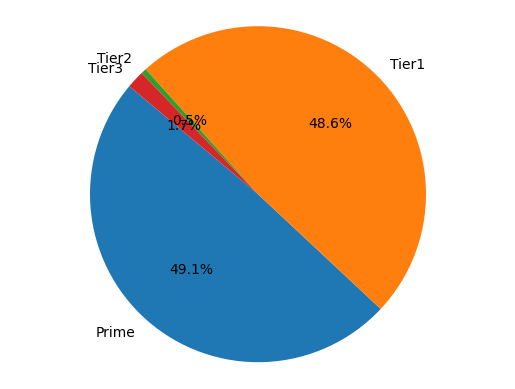

In [60]:
# Data to plot
labels = ['Prime', 'Tier1', 'Tier2', 'Tier3']
sizes = [primeData.shape[0], tier1.shape[0], tier2.shape[0], tier3.shape[0]]

sizes

# Plotting the pie chart
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)

# Equal aspect ratio ensures that pie is drawn as a circle.
plt.axis('equal')  

# Show the pie chart
plt.show()


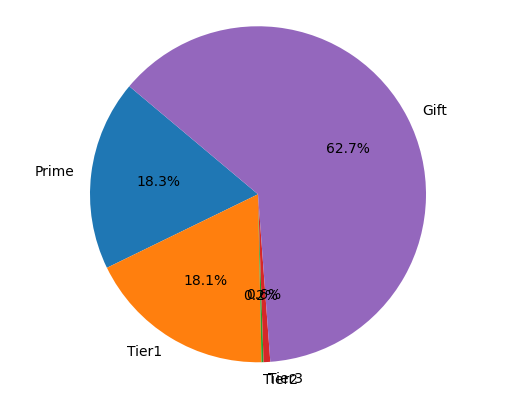

In [61]:
# Data to plot
labels = ['Prime', 'Tier1', 'Tier2', 'Tier3','Gift']
sizes = [primeData.shape[0], tier1.shape[0], tier2.shape[0], tier3.shape[0],giftedData.shape[0]]

sizes

# Plotting the pie chart
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)

# Equal aspect ratio ensures that pie is drawn as a circle.
plt.axis('equal')  

# Show the pie chart
plt.show()


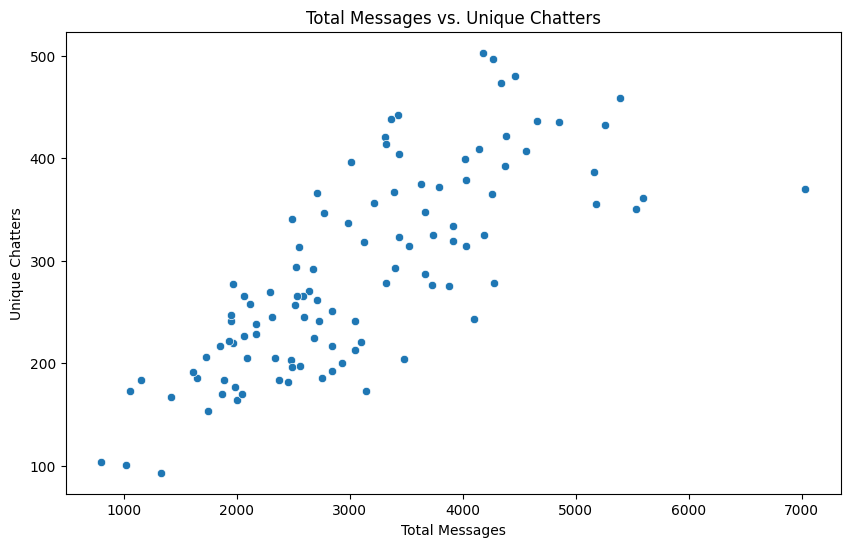

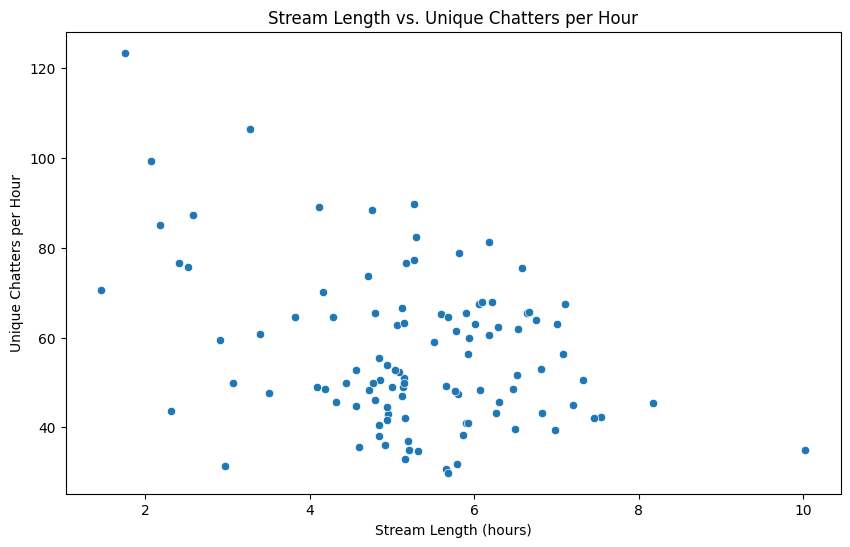

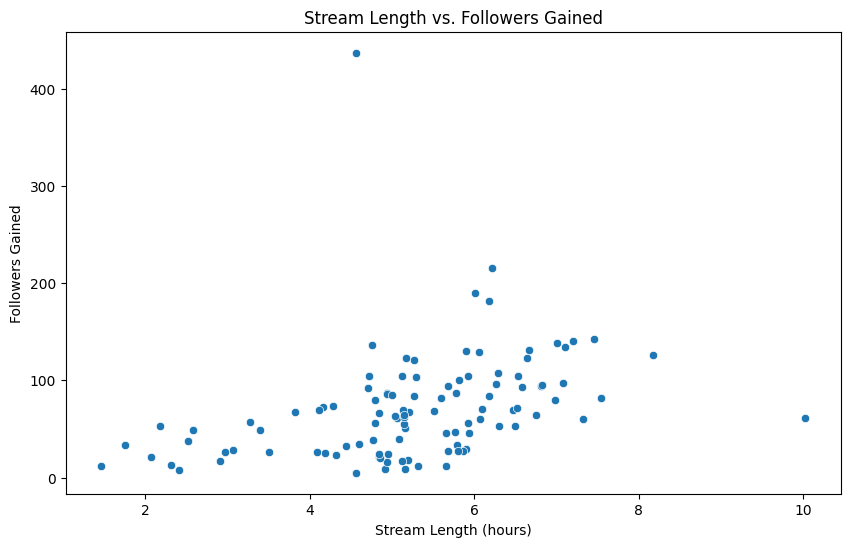

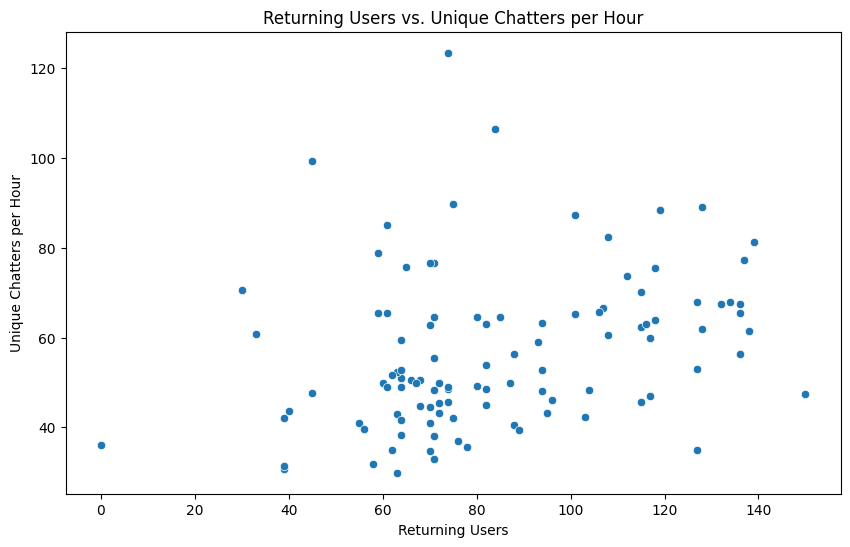

In [62]:

# Scatter plot for Total Messages vs. Unique Chatters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=stream_stats['total_messages'], y=stream_stats['unique_chatters'])
plt.title('Total Messages vs. Unique Chatters')
plt.xlabel('Total Messages')
plt.ylabel('Unique Chatters')
plt.show()

# Scatter plot for Stream Length vs. Unique Chatters per Hour
plt.figure(figsize=(10, 6))
sns.scatterplot(x=stream_stats['stream_length_hour'], y=stream_stats['unique_chatters_per_hour'])
plt.title('Stream Length vs. Unique Chatters per Hour')
plt.xlabel('Stream Length (hours)')
plt.ylabel('Unique Chatters per Hour')
plt.show()

# Scatter plot for Stream Length vs. Followers Gained
plt.figure(figsize=(10, 6))
sns.scatterplot(x=stream_stats['stream_length_hour'], y=stream_stats['follow'])
plt.title('Stream Length vs. Followers Gained')
plt.xlabel('Stream Length (hours)')
plt.ylabel('Followers Gained')
plt.show()

# Scatter plot for Returning Users vs. Unique Chatters per Hour
plt.figure(figsize=(10, 6))
sns.scatterplot(x=stream_stats['returning_count'], y=stream_stats['unique_chatters_per_hour'])
plt.title('Returning Users vs. Unique Chatters per Hour')
plt.xlabel('Returning Users')
plt.ylabel('Unique Chatters per Hour')
plt.show()

In [63]:
# Split the 'games' column into lists
stream_stats['games_list'] = stream_stats['games'].str.split(', ')

# Get the unique games across all streams
unique_games = set(sum(stream_stats['games_list'].tolist(), []))- {''}

# Create a column for each unique game
for game in unique_games:
    stream_stats[game] = stream_stats['games_list'].apply(lambda x: 1 if game in x else 0)

# Drop the temporary 'games_list' column
stream_stats.drop(columns=['games_list'], inplace=True)


In [64]:
stream_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106 entries, 0 to 105
Data columns (total 62 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   stream                           106 non-null    int64  
 1   first_messages                   106 non-null    int64  
 2   total_messages                   106 non-null    int64  
 3   unique_chatters                  106 non-null    int64  
 4   stream_length                    106 non-null    float64
 5   stream_length_hour               106 non-null    float64
 6   stream_length_per_firt           106 non-null    float64
 7   unique_chatters_per_hour         106 non-null    float64
 8   first_messages_avg               106 non-null    float64
 9   unique_chatters_per_hour_avg     106 non-null    float64
 10  users                            106 non-null    object 
 11  returning_users                  106 non-null    object 
 12  returning_count       

In [65]:
unique_games

{'chainedtogether',
 'codbo6',
 'cs',
 'deadatnigth',
 'deadlock',
 'er',
 'fortnite',
 'irl',
 'jc',
 'lol',
 'marbels',
 'mc',
 'ow2',
 'parasocial',
 'phazmo',
 'pubg',
 'rdr2',
 're2',
 're3',
 're4',
 'roblox',
 'special',
 'tf2',
 'valo'}

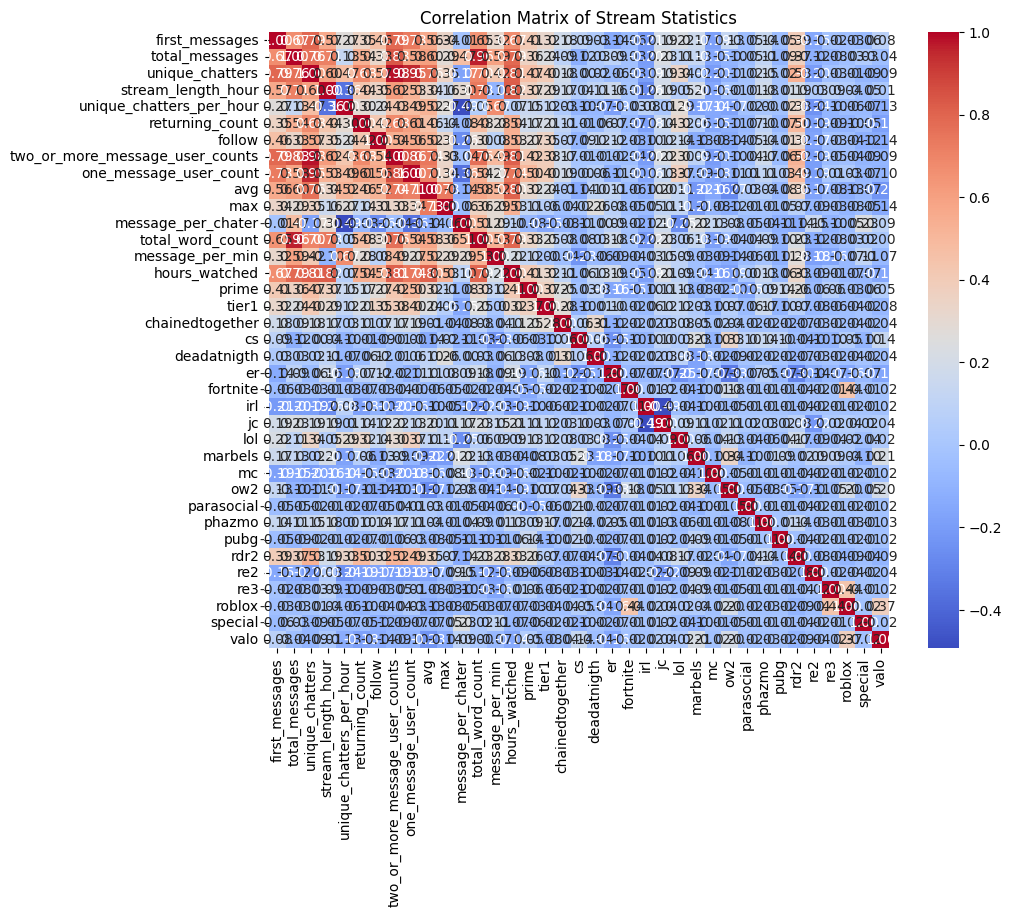

In [66]:
# Correlation matrix for selected columns
correlation_matrix = stream_stats[[ 'first_messages',
                                    'total_messages',
                                    'unique_chatters',
                                    'stream_length_hour',
                                    'unique_chatters_per_hour',
                                    'returning_count',
                                    'follow',
                                    'two_or_more_message_user_counts',
                                    'one_message_user_count',
                                    'avg',
                                    'max',
                                    'message_per_chater',
                                    'total_word_count',
                                    'message_per_min',
                                    'hours_watched',
                                    'prime',
                                    'tier1',
                                    'chainedtogether',
                                    'cs',
                                    'deadatnigth',
                                    'er',
                                    'fortnite',
                                    'irl',
                                    'jc',
                                    'lol',
                                    'marbels',
                                    'mc',
                                    'ow2',
                                    'parasocial',
                                    'phazmo',
                                    'pubg',
                                    'rdr2',
                                    're2',
                                    're3',
                                    'roblox',
                                    'special',
                                    'valo'
                                    ]].corr()

# Plotting the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Stream Statistics')
plt.show()

In [67]:
#stream_stats.to_csv('combined_output.csv', index=False)

In [68]:
# Define game columns
game_columns = unique_games

# Initialize a dictionary to hold aggregated data
game_impact_data = {}

# Aggregate metrics for each game
for game in game_columns:
    # Filter the dataset for streams where the specific game was played
    game_data = stream_stats[stream_stats[game] == 1]
    
    # Calculate average metrics for the filtered data
    average_metrics = {
        'Average Total Messages': game_data['total_messages'].mean(),
        'Average Unique Chatters': game_data['unique_chatters'].mean(),
        'Average Hours Watched': game_data['hours_watched'].mean(),
        'Average Total Word Count': game_data['total_word_count'].mean(),
        'Average Returning User Count': game_data['returning_count_avg'].mean(),
        'Average Viewer Count': game_data['avg'].mean(),
        'Max Viewer Count': game_data['max'].mean()
    }
    
    # Store the averages in the dictionary
    game_impact_data[game] = average_metrics

# Convert the dictionary to a DataFrame for better visualization
game_impact_df = pd.DataFrame(game_impact_data).T
game_impact_df.reset_index(inplace=True)
game_impact_df.columns = ['Game', 'Average Total Messages', 'Average Unique Chatters', 
                          'Average Hours Watched', 'Average Total Word Count', 
                          'Average Returning User Count','Average Viewer Count',
                          'Max Viewer Count']



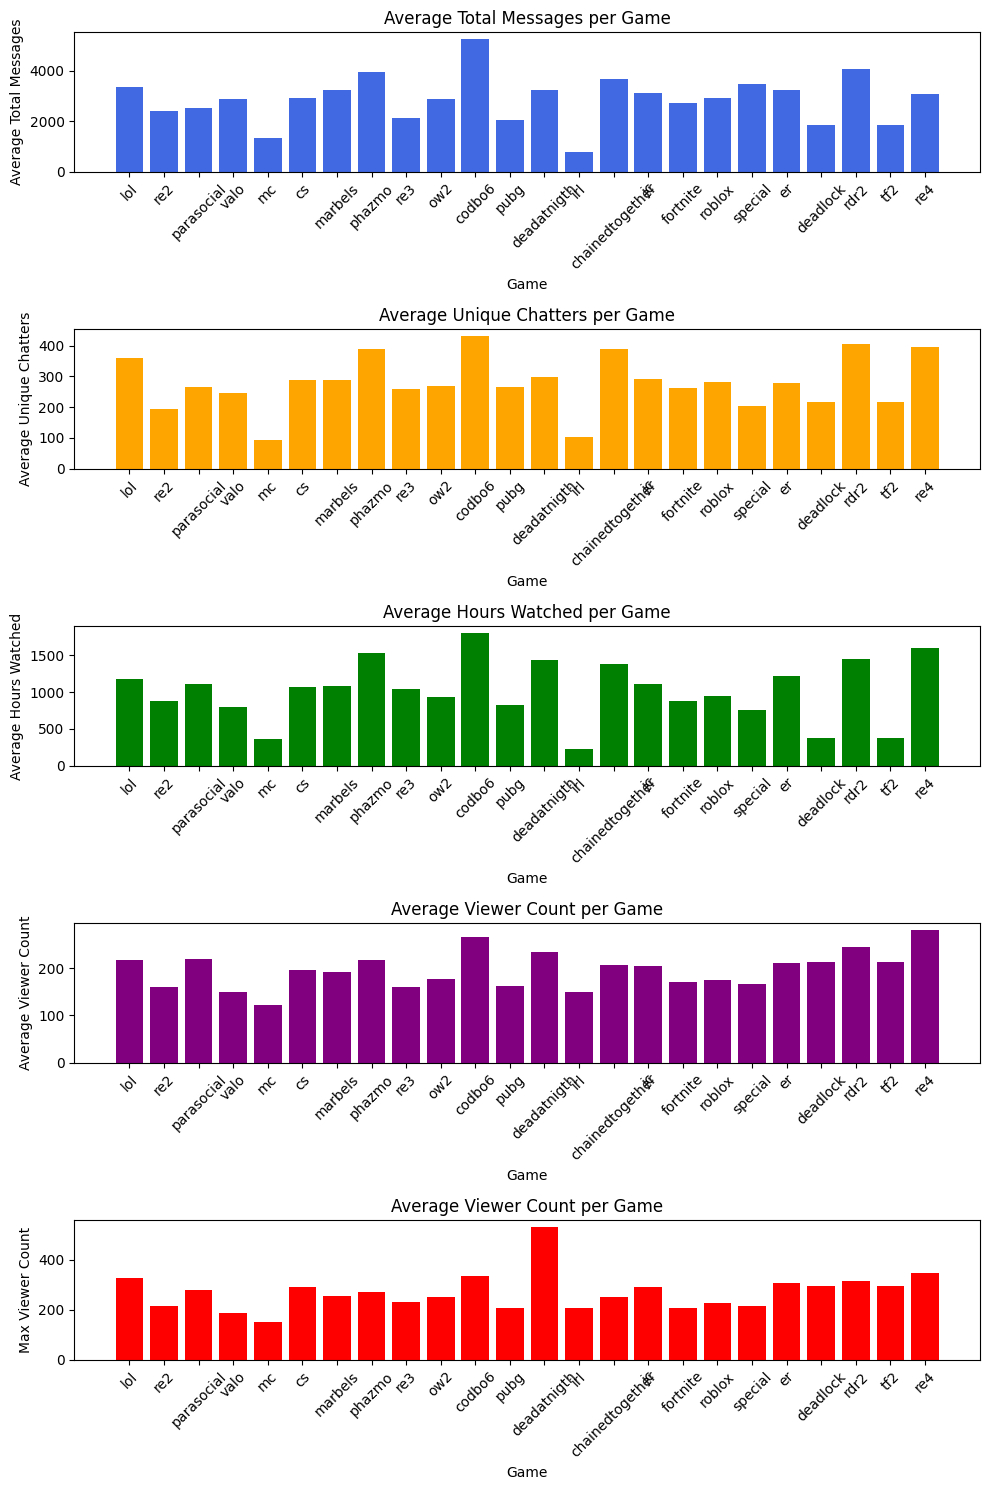

In [69]:
# Set up the figure and axes for subplots
fig, ax = plt.subplots(5, 1, figsize=(10, 15))

# Bar chart for Average Total Messages
ax[0].bar(game_impact_df['Game'], game_impact_df['Average Total Messages'], color='royalblue')
ax[0].set_title('Average Total Messages per Game')
ax[0].set_xlabel('Game')
ax[0].set_ylabel('Average Total Messages')
ax[0].tick_params(axis='x', rotation=45)

# Bar chart for Average Unique Chatters
ax[1].bar(game_impact_df['Game'], game_impact_df['Average Unique Chatters'], color='orange')
ax[1].set_title('Average Unique Chatters per Game')
ax[1].set_xlabel('Game')
ax[1].set_ylabel('Average Unique Chatters')
ax[1].tick_params(axis='x', rotation=45)

# Bar chart for Average Hours Watched
ax[2].bar(game_impact_df['Game'], game_impact_df['Average Hours Watched'], color='green')
ax[2].set_title('Average Hours Watched per Game')
ax[2].set_xlabel('Game')
ax[2].set_ylabel('Average Hours Watched')
ax[2].tick_params(axis='x', rotation=45)

# Bar chart for Average Hours Watched
ax[3].bar(game_impact_df['Game'], game_impact_df['Average Viewer Count'], color='purple')
ax[3].set_title('Average Viewer Count per Game')
ax[3].set_xlabel('Game')
ax[3].set_ylabel('Average Viewer Count')
ax[3].tick_params(axis='x', rotation=45)

# Bar chart for Average Hours Watched
ax[4].bar(game_impact_df['Game'], game_impact_df['Max Viewer Count'], color='red')
ax[4].set_title('Average Viewer Count per Game')
ax[4].set_xlabel('Game')
ax[4].set_ylabel('Max Viewer Count')
ax[4].tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()


In [70]:
# Extract only the date (without time)
data['date_only'] = data['date'].dt.date

# Group by 'stream' and find the first message date
stream_date = data.groupby('stream')['date_only'].min().reset_index()

# Rename the columns appropriately
stream_date.columns = ['stream', 'stream_date']

# Assuming stream_stats is the existing DataFrame you want to update
# Merge the stream_date with the stream_stats DataFrame
stream_stats = stream_stats.merge(stream_date, on='stream', how='left')

# Now, stream_stats will have a new column 'stream_date' with the date of the first message for each stream.


In [71]:
stream_stats['stream_date'].tail(5)

101    2024-09-02
102    2024-09-03
103    2024-09-04
104    2024-09-05
105    2024-09-06
Name: stream_date, dtype: object

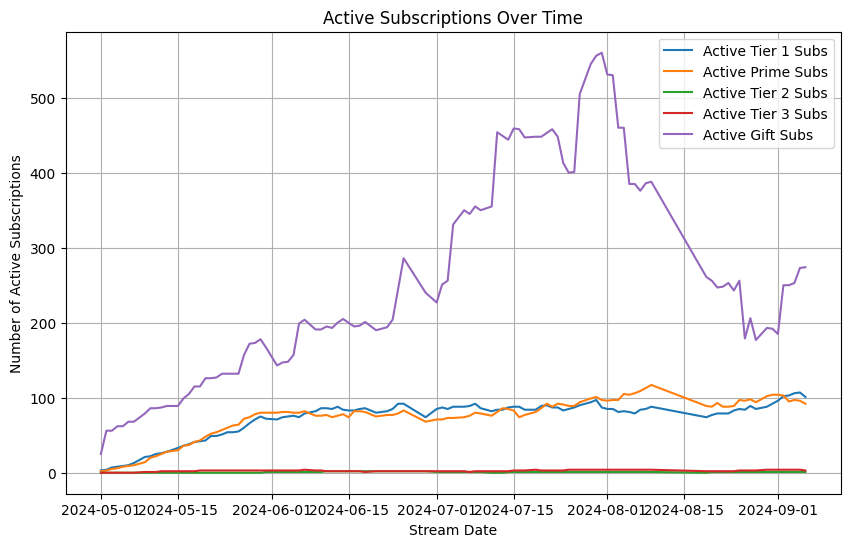

In [72]:
# Convert stream_date to datetime if it is not already
stream_stats['stream_date'] = pd.to_datetime(stream_stats['stream_date'])

# Tier1
active_subs = []

for i in range(len(stream_stats)):
    current_date = stream_stats.iloc[i]['stream_date']
    
    mask = (stream_stats['stream_date'] <= current_date) & \
           (stream_stats['stream_date'] > current_date - pd.Timedelta(days=30))
    active_sub_count = stream_stats.loc[mask, 'tier1'].sum()
    
    active_subs.append(active_sub_count)
stream_stats['active_subs'] = active_subs

# PRIME
active_prime = []

for i in range(len(stream_stats)):
    current_date = stream_stats.iloc[i]['stream_date']
    
    mask = (stream_stats['stream_date'] <= current_date) & \
           (stream_stats['stream_date'] > current_date - pd.Timedelta(days=30))
    active_prime_count = stream_stats.loc[mask, 'prime'].sum()
    
    active_prime.append(active_prime_count)
stream_stats['active_prime'] = active_prime

# Tier2
active_tier2 = []

for i in range(len(stream_stats)):
    current_date = stream_stats.iloc[i]['stream_date']
    
    mask = (stream_stats['stream_date'] <= current_date) & \
           (stream_stats['stream_date'] > current_date - pd.Timedelta(days=30))
    active_tier2_count = stream_stats.loc[mask, 'tier2'].sum()
    
    active_tier2.append(active_tier2_count)
stream_stats['active_tier2'] = active_tier2

# Tier3
active_tier3 = []

for i in range(len(stream_stats)):
    current_date = stream_stats.iloc[i]['stream_date']
    
    mask = (stream_stats['stream_date'] <= current_date) & \
           (stream_stats['stream_date'] > current_date - pd.Timedelta(days=30))
    active_tier3_count = stream_stats.loc[mask, 'tier3'].sum()
    
    active_tier3.append(active_tier3_count)
stream_stats['active_tier3'] = active_tier3

# Tier3
active_gift = []

for i in range(len(stream_stats)):
    current_date = stream_stats.iloc[i]['stream_date']
    
    mask = (stream_stats['stream_date'] <= current_date) & \
           (stream_stats['stream_date'] > current_date - pd.Timedelta(days=30))
    active_gift_count = stream_stats.loc[mask, 'gift'].sum()
    
    active_gift.append(active_gift_count)
stream_stats['active_gift'] = active_gift

# Plot the data
plt.figure(figsize=(10, 6))

# Plot each subscription type with labels
plt.plot(stream_stats['stream_date'], stream_stats['active_subs'], label='Active Tier 1 Subs')
plt.plot(stream_stats['stream_date'], stream_stats['active_prime'], label='Active Prime Subs')
plt.plot(stream_stats['stream_date'], stream_stats['active_tier2'], label='Active Tier 2 Subs')
plt.plot(stream_stats['stream_date'], stream_stats['active_tier3'], label='Active Tier 3 Subs')
plt.plot(stream_stats['stream_date'], stream_stats['active_gift'], label='Active Gift Subs')

# Add title and labels
plt.title('Active Subscriptions Over Time')
plt.xlabel('Stream Date')
plt.ylabel('Number of Active Subscriptions')

# Display grid and legend
plt.grid(True)
plt.legend()

# Show the plot
plt.show()

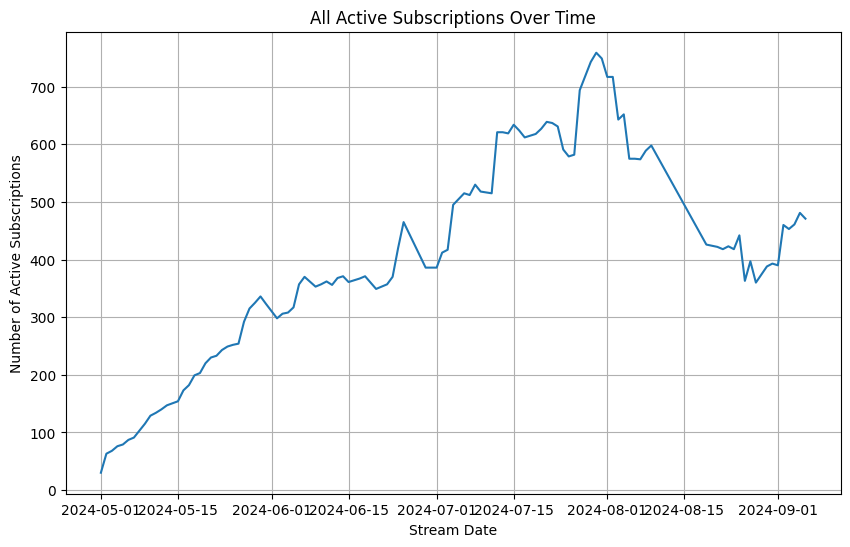

In [73]:
# Calculate the total subs for each stream
stream_stats['all_sub'] = stream_stats['tier1'] + stream_stats['tier2'] + stream_stats['tier3'] + stream_stats['prime'] + stream_stats['gift']

# Initialize a list to store the active subs for each date
active_all_subs = []

# Loop through each date in the dataframe
for i in range(len(stream_stats)):
    current_date = stream_stats.iloc[i]['stream_date']
    
    # Get the total subs in the last 30 days
    mask = (stream_stats['stream_date'] <= current_date) & \
           (stream_stats['stream_date'] > current_date - pd.Timedelta(days=30))
    active_sub_count = stream_stats.loc[mask, 'all_sub'].sum()
    
    active_all_subs.append(active_sub_count)

# Add this new series to the original dataframe
stream_stats['all_active_subs'] = active_all_subs

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(stream_stats['stream_date'], stream_stats['all_active_subs'])
plt.title('All Active Subscriptions Over Time')
plt.xlabel('Stream Date')
plt.ylabel('Number of Active Subscriptions')
plt.grid(True)
plt.show()

In [74]:
stream_stats['ad_rev'] = stream_stats['hours_watched'] * 0.72 / 100

stream_stats['ad_rev']

0       4.565826
1       5.420624
2       4.825044
3       4.641966
4       5.545264
         ...    
101    11.332248
102     2.447640
103    10.808340
104     9.210600
105    12.986880
Name: ad_rev, Length: 106, dtype: float64

In [75]:
stream_stats.tail(3)

,stream,first_messages,total_messages,unique_chatters,stream_length,stream_length_hour,stream_length_per_firt,unique_chatters_per_hour,first_messages_avg,unique_chatters_per_hour_avg,...,re4,stream_date,active_subs,active_prime,active_tier2,active_tier3,active_gift,all_sub,all_active_subs,ad_rev
103,103,120,4340,473,18962.0,5.267222,22.782407,89.800654,89.894231,56.318060,...,0,2024-09-04,106.0,97.0,1.0,4.0,253.0,12.0,461.0,10.80834
104,104,123,3316,414,21930.0,6.091667,20.191518,67.961696,90.209524,56.428952,...,0,2024-09-05,107.0,96.0,1.0,4.0,273.0,30.0,481.0,9.21060
105,105,105,5262,432,24320.0,6.755556,15.542763,63.947368,90.349057,56.499881,...,0,2024-09-06,101.0,92.0,1.0,3.0,274.0,7.0,471.0,12.98688


In [76]:
#stream_stats.to_csv('combined_output.csv', index=False)

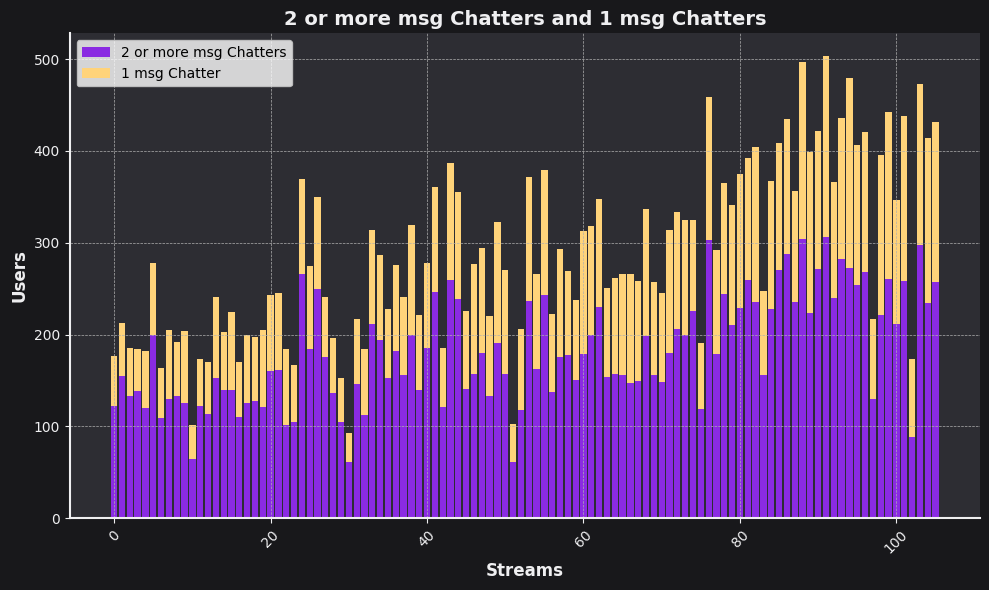

In [77]:
#one_message_user_count
#two_or_more_message_user_counts

# Plot the bars with specified colors
fig, ax = plt.subplots(figsize=(10, 6))  # Set figure size

# Bar plot for all chatters
ax.bar(stream_stats.index, 
       stream_stats['two_or_more_message_user_counts'], 
       label='2 or more msg Chatters', 
       color='#8A2BE2',  # Custom color for the first set of bars (purple)
      )

# Bar plot for first-time chatters (stacked on top)
ax.bar(stream_stats.index, 
       stream_stats['one_message_user_count'],
       bottom=stream_stats['two_or_more_message_user_counts'],
       label='1 msg Chatter', 
       color='#FFD37A',  # Custom color for the second set of bars (yellow)
      )

# Set the background color of the figure (entire plot area)
fig.patch.set_facecolor('#18181B')

# Labels and title with custom color
label_color = '#EFEFF1'  # Color for the labels
ax.set_xlabel('Streams', fontsize=12, fontweight='bold', color=label_color)
ax.set_ylabel('Users', fontsize=12, fontweight='bold', color=label_color)
ax.set_title('2 or more msg Chatters and 1 msg Chatters', fontsize=14, fontweight='bold', color=label_color)

# Customizing the plot background and axes spines
ax.set_facecolor('#2D2D33')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_color(label_color)
ax.spines['bottom'].set_color(label_color)

# Adding legend to differentiate the bars
ax.legend()

# Rotating x-axis labels
plt.xticks(rotation=45, fontsize=10)

# Changing tick colors
ax.tick_params(axis='y', colors=label_color)
ax.tick_params(axis='x', colors=label_color)

# Adding grid with custom style
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Display the plot
plt.tight_layout()
plt.show()


In [78]:
stream_stats['2mgs_per'] = stream_stats['two_or_more_message_user_counts'] / (stream_stats['two_or_more_message_user_counts'] + stream_stats['one_message_user_count']) * 100
stream_stats['1mgs_per'] = 100 - stream_stats['2mgs_per']

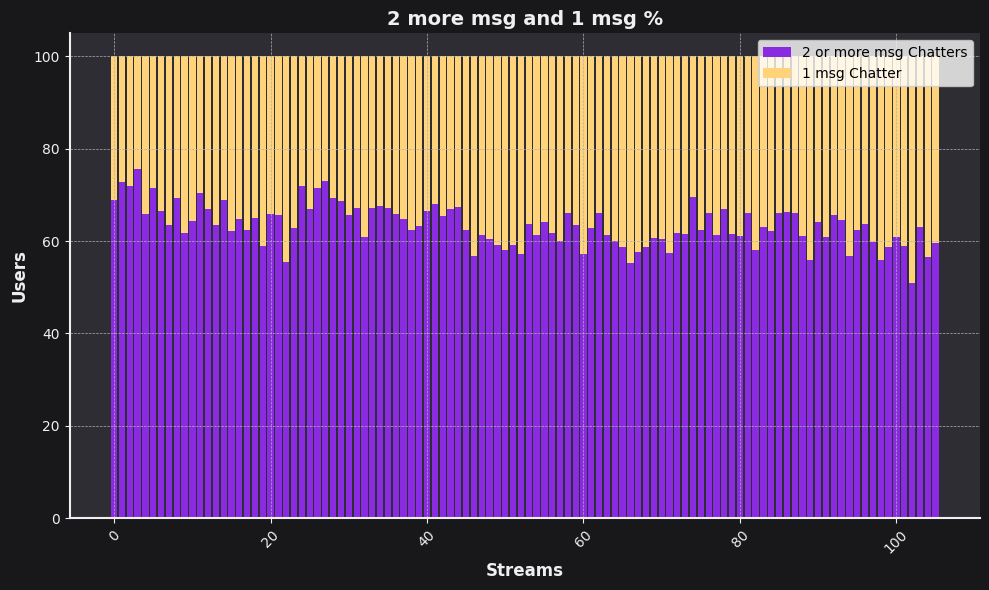

In [79]:
# Plot the bars with specified colors
fig, ax = plt.subplots(figsize=(10, 6))  # Set figure size

# Bar plot for all chatters
ax.bar(stream_stats.index, 
       stream_stats['2mgs_per'], 
       label='2 or more msg Chatters', 
       color='#8A2BE2',  # Custom color for the first set of bars (purple)
      )

# Bar plot for first-time chatters (stacked on top)
ax.bar(stream_stats.index, 
       stream_stats['1mgs_per'],
       bottom=stream_stats['2mgs_per'],
       label='1 msg Chatter', 
       color='#FFD37A',  # Custom color for the second set of bars (yellow)
      )

# Set the background color of the figure (entire plot area)
fig.patch.set_facecolor('#18181B')

# Labels and title with custom color
label_color = '#EFEFF1'  # Color for the labels
ax.set_xlabel('Streams', fontsize=12, fontweight='bold', color=label_color)
ax.set_ylabel('Users', fontsize=12, fontweight='bold', color=label_color)
ax.set_title('2 more msg and 1 msg %', fontsize=14, fontweight='bold', color=label_color)

# Customizing the plot background and axes spines
ax.set_facecolor('#2D2D33')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_color(label_color)
ax.spines['bottom'].set_color(label_color)

# Adding legend to differentiate the bars
ax.legend()

# Rotating x-axis labels
plt.xticks(rotation=45, fontsize=10)

# Changing tick colors
ax.tick_params(axis='y', colors=label_color)
ax.tick_params(axis='x', colors=label_color)

# Adding grid with custom style
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Display the plot
plt.tight_layout()
plt.show()


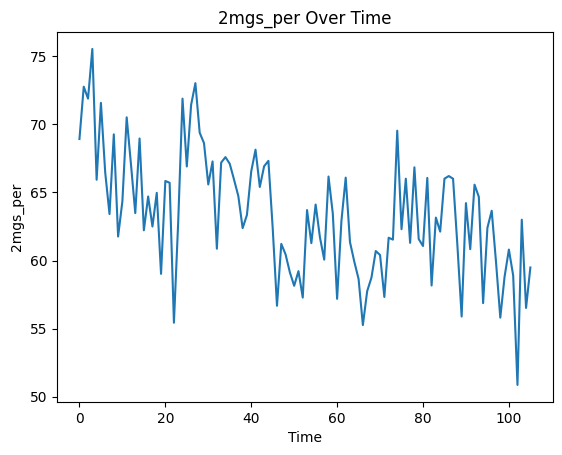

In [80]:
# Assuming stream_stats has a 'time' column or datetime index
plt.plot(stream_stats['stream'], stream_stats['2mgs_per'])
plt.title('2mgs_per Over Time')
plt.xlabel('Time')
plt.ylabel('2mgs_per')
plt.show()

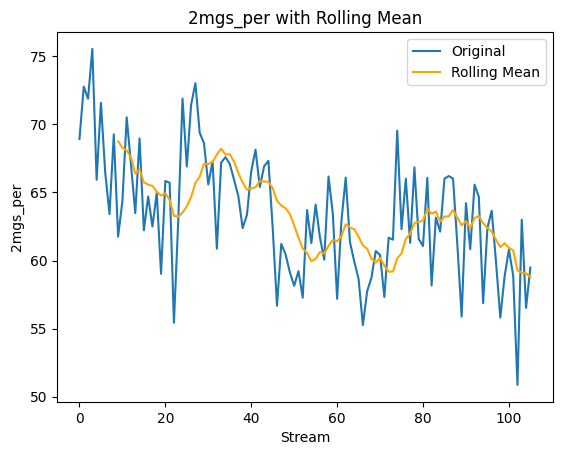

In [87]:
stream_stats['rolling_mean'] = stream_stats['2mgs_per'].rolling(window=10).mean()

plt.plot(stream_stats['stream'], stream_stats['2mgs_per'], label='Original')
plt.plot(stream_stats['stream'], stream_stats['rolling_mean'], label='Rolling Mean', color='orange')
plt.title('2mgs_per with Rolling Mean')
plt.xlabel('Stream')
plt.ylabel('2mgs_per')
plt.legend()
plt.show()


In [84]:
from sklearn.linear_model import LinearRegression

# Assuming 'time' is in datetime format, convert to numerical format
stream_stats['time_ordinal'] = pd.to_datetime(stream_stats['stream_date']).map(pd.Timestamp.toordinal)

X = stream_stats['time_ordinal'].values.reshape(-1, 1)
y = stream_stats['2mgs_per'].values

model = LinearRegression()
model.fit(X, y)

slope = model.coef_[0]

if slope > 0:
    print("The data is trending upwards.")
elif slope < 0:
    print("The data is trending downwards.")
else:
    print("The data is stagnating.")

The data is trending upwards.


In [83]:
import pymannkendall as mk

result = mk.original_test(stream_stats['2mgs_per'])
print(result)

Mann_Kendall_Test(trend='decreasing', h=True, p=2.222279560371021e-08, z=-5.593741338861555, Tau=-0.3683737646001797, s=-2050.0, var_s=134177.33333333334, slope=-0.07987937317130091, intercept=67.44682260471073)
